# **Correlation Study**

## Objectives

* Identify variables with most significant correlation to the sale price 
to answer the first business requirement.

## Inputs

* inputs/datasets/cleaned/TrainSet.csv
* inputs/datasets/cleaned/TestSet.csv

## Outputs

* generate a list with variables to engineer

## Crisp-DM

* Data Preparation


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/house-prices-ml/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/house-prices-ml'

# Load Cleaned Data

Load test and train sests and display head to check that it has been loaded.

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)


1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1232       0.0           2.0           Av         724          GLQ   
1      1445     689.0           5.0           No           0          Unf   
2      1337       0.0           3.0           Mn         699          GLQ   

   BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  ...  LotFrontage  \
0        508            0.0         632         none  ...         64.0   
1        844          268.0         441          Unf  ...         69.5   
2        638            0.0         531          RFn  ...         65.0   

   MasVnrArea OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  WoodDeckSF  \
0        82.0           0            5            7         1232         0.0   
1         0.0          60            6            6          844         0.0   
2         0.0          39            5            7         1337         0.0   

   YearBuilt  YearRemodAdd  SalePrice  
0       2007          2007     194500  
1       1916          1994     214500  
2       2003          2003     185000  

[3 rows x 24 columns]

In [5]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0       864       0.0           3.0           No         432          ALQ   
1       864       0.0           3.0           No         398          ALQ   
2       840     828.0           3.0           No           0         none   

   BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  ...  LotFrontage  \
0        432            0.0           0         none  ...         70.0   
1        317            0.0         720          RFn  ...         60.0   
2        840            0.0         500          RFn  ...         72.0   

   MasVnrArea OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  WoodDeckSF  \
0         0.0           0            5            4          864         0.0   
1         0.0           0            8            5          864         0.0   
2       101.0          68            5            7          840         0.0   

   YearBuilt  YearRemodAdd  SalePrice  
0       1971          1971     115000  
1       1950          2002     129000  
2       2003          2003     180000  

[3 rows x 24 columns]

---

# Feature Engineering

We will look again at the pandas profile report, this time with the cleaned data and no missing values. 

In [6]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

### Dealing with Feature Engineering


Our data has 4 categorical variables which must be converted to a numerical data type values to facilitate the correlation calculations.

First we will use categorical encoding to replaces categories with ordinal numbers
The variables we need are: 'BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'


In [7]:
ordinal_vars =['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
ordinal_vars

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

Now we create a new dataframe with these select variables.

In [8]:
ordinal_vars_engineering = TrainSet[ordinal_vars].copy()
ordinal_vars_engineering.head(3)


BsmtExposure BsmtFinType1 GarageFinish KitchenQual
0           Av          GLQ         none          Gd
1           No          Unf          Unf          Gd
2           Mn          GLQ          RFn          Gd

Now we apply the tranformations, assess the variable distributions and select the most suitable method for each based on the evidence the analysis presents.

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



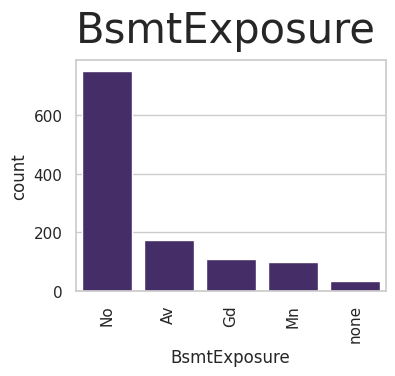

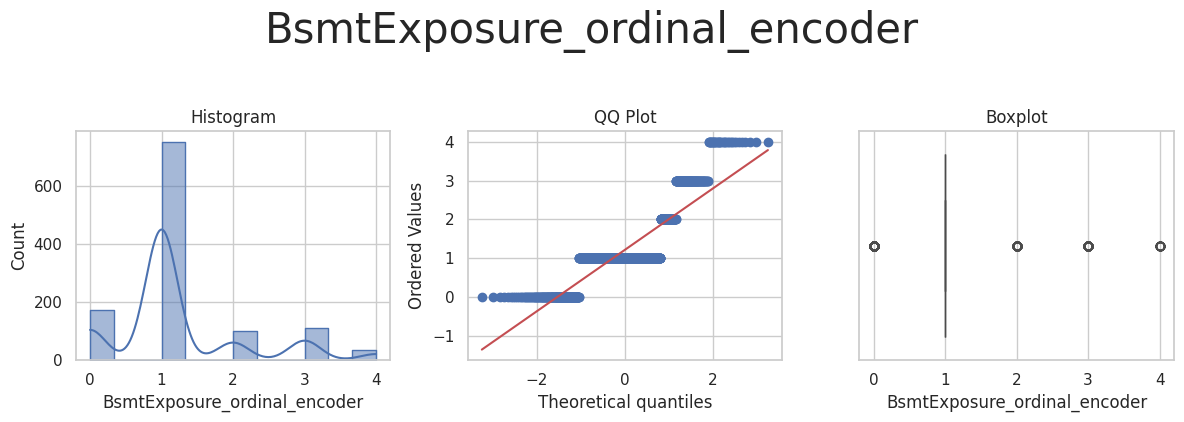



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



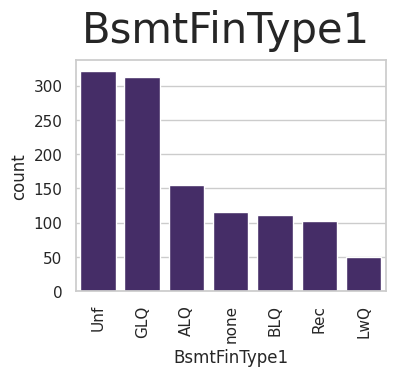

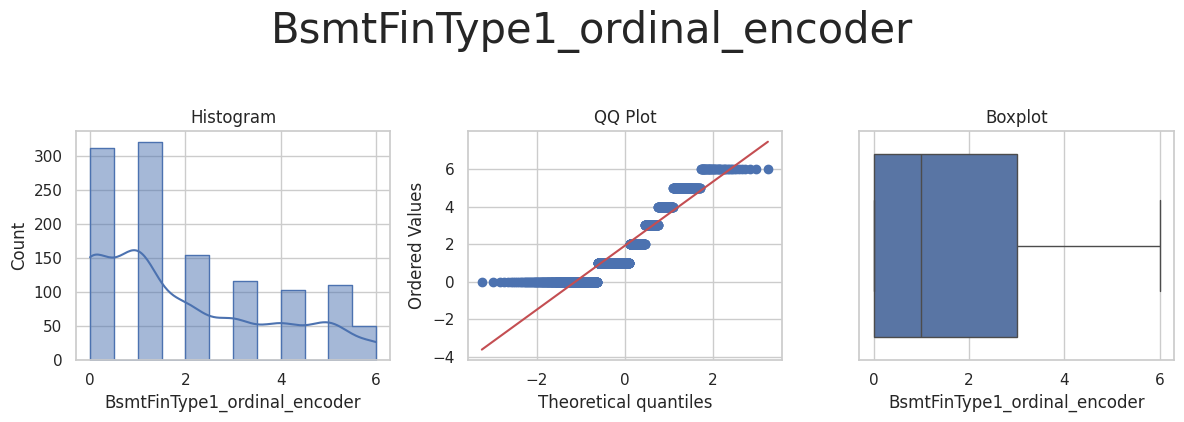



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



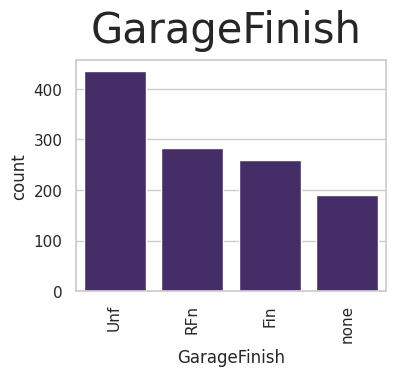

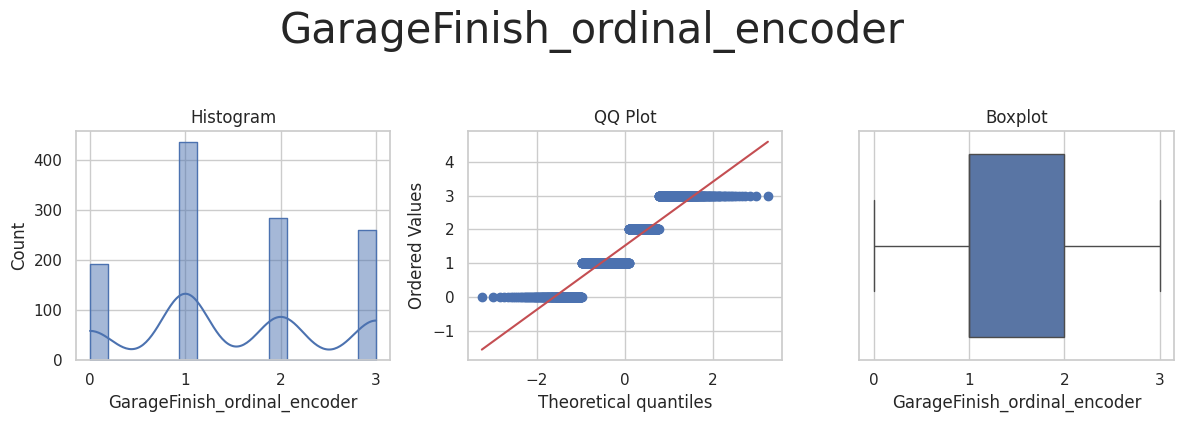



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



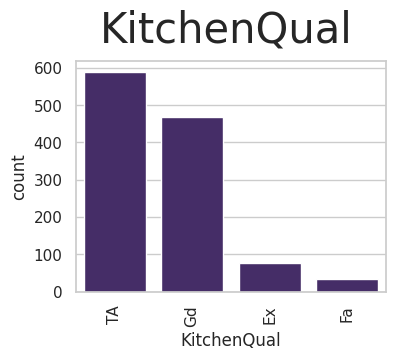

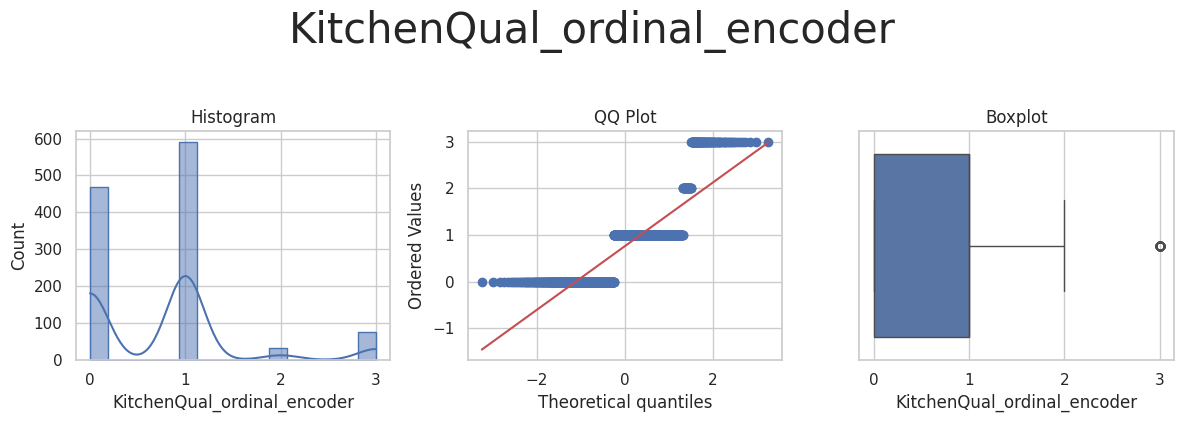

In [9]:
ordinal_vars_engineering = FeatureEngineeringAnalysis(
    df=ordinal_vars_engineering, analysis_type='ordinal_encoder')


As applying the ordinal encoder does not significantly affect the distribution and range of the variables we will use this method on our categorical variables.
Conclusion: We can apply Ordinal Encoder to: 'BsmtExposure', 'BsmtFinType1' and 'GarageFinish', 'KitchenQual'.

In [10]:
encoder = OrdinalEncoder(encoding_method='arbitrary', variables = ordinal_vars)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


### Numerical Transformations

All remaining variables are numerical, and first we create a list for them.


In [11]:
numerical_vars = ['1stFlrSF','2ndFlrSF','BedroomAbvGr','BsmtFinSF1',
'BsmtUnfSF','EnclosedPorch','GarageArea','GarageYrBlt','GrLivArea',
'LotArea','LotFrontage','MasVnrArea','OpenPorchSF','OverallCond','OverallQual',
'TotalBsmtSF','WoodDeckSF','YearBuilt','YearRemodAdd']
numerical_vars

['1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'EnclosedPorch',
 'GarageArea',
 'GarageYrBlt',
 'GrLivArea',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd']

Now create a dataframe

In [12]:
numerical_vars_engineering = TrainSet[numerical_vars].copy()
numerical_vars_engineering.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtFinSF1  BsmtUnfSF  EnclosedPorch  \
0      1232       0.0           2.0         724        508            0.0   
1      1445     689.0           5.0           0        844          268.0   
2      1337       0.0           3.0         699        638            0.0   

   GarageArea  GarageYrBlt  GrLivArea  LotArea  LotFrontage  MasVnrArea  \
0         632       2007.0       1232     7314         64.0        82.0   
1         441       1930.0       2134    11888         69.5         0.0   
2         531       2003.0       1337     8450         65.0         0.0   

   OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  WoodDeckSF  YearBuilt  \
0            0            5            7         1232         0.0       2007   
1           60            6            6          844         0.0       1916   
2           39            5            7         1337         0.0       2003   

   YearRemodAdd  
0          2007  
1          1994  
2          2003

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



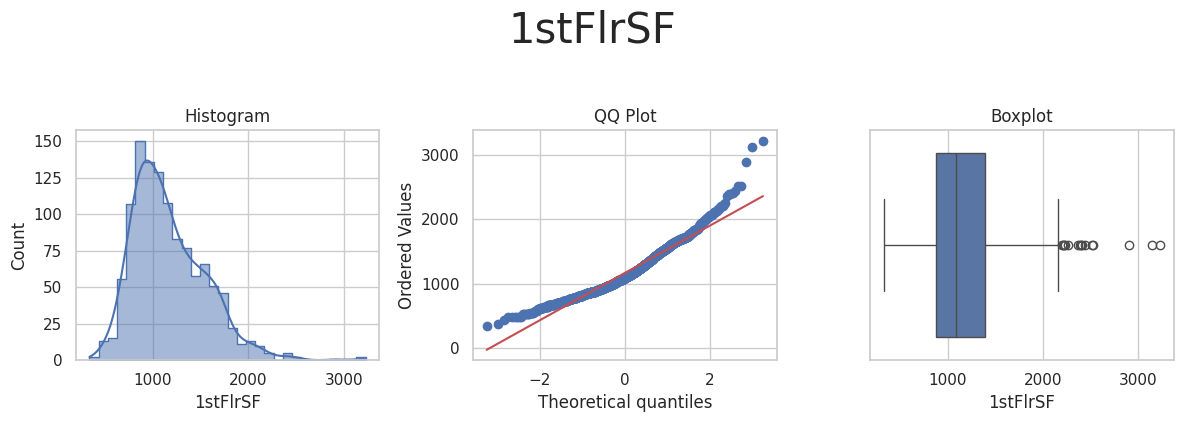

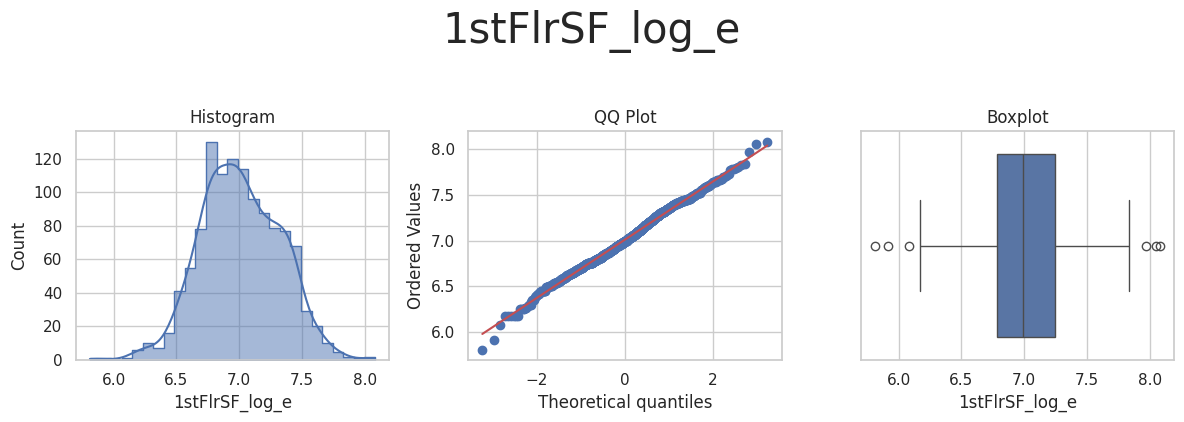

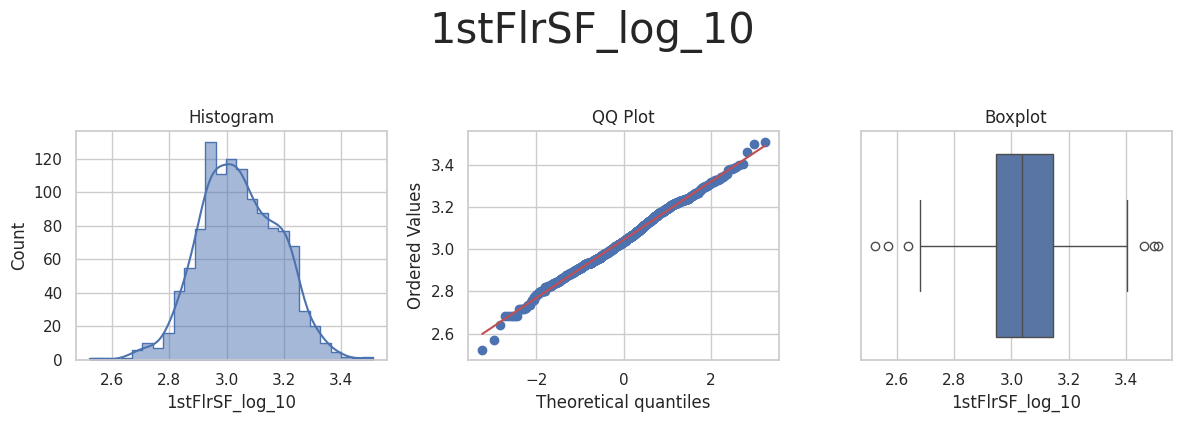

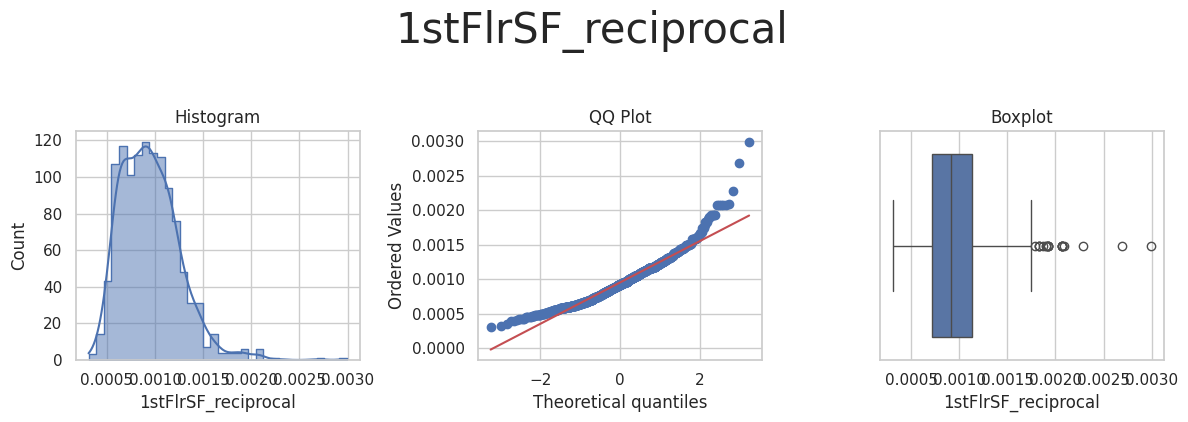

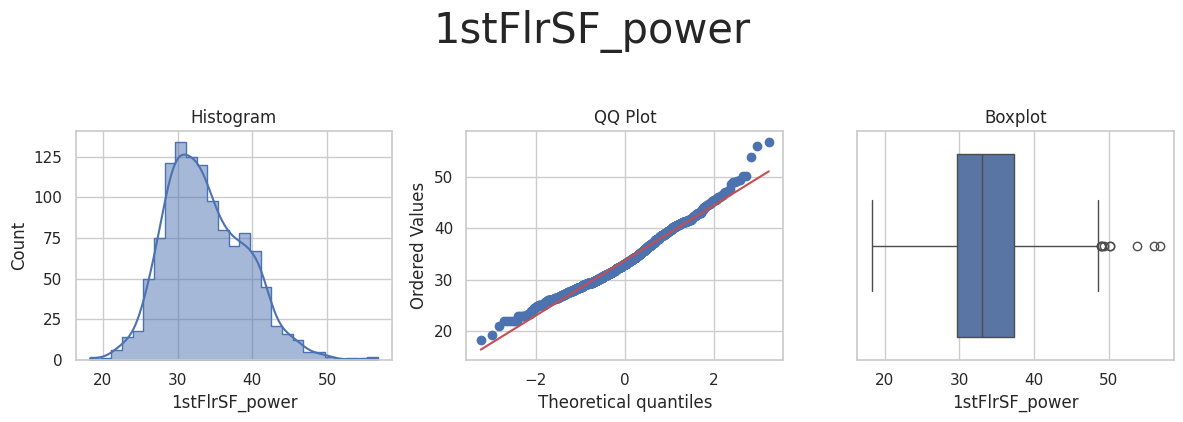

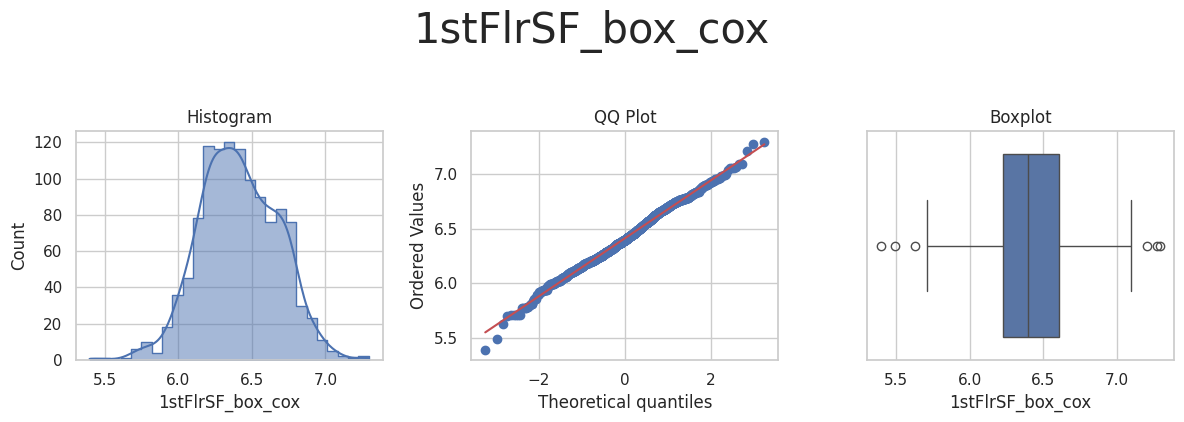

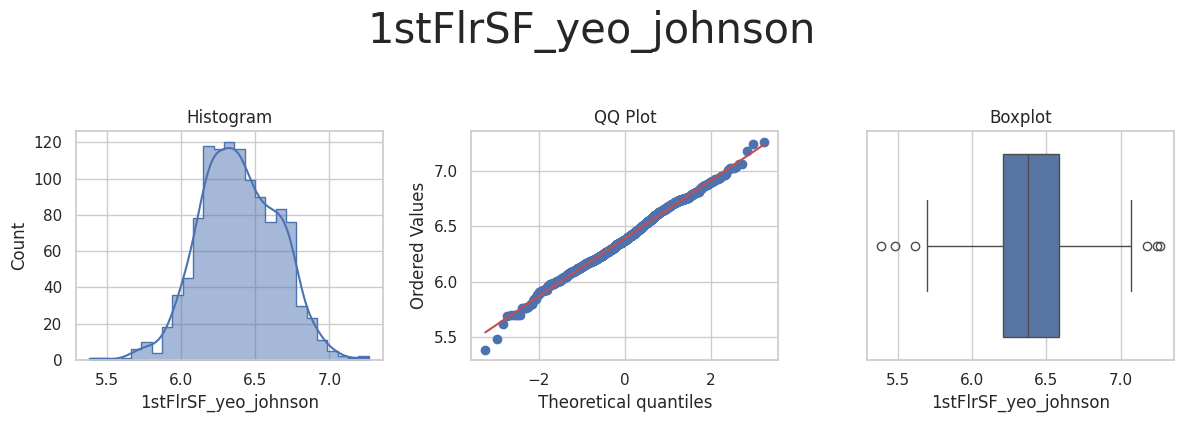



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



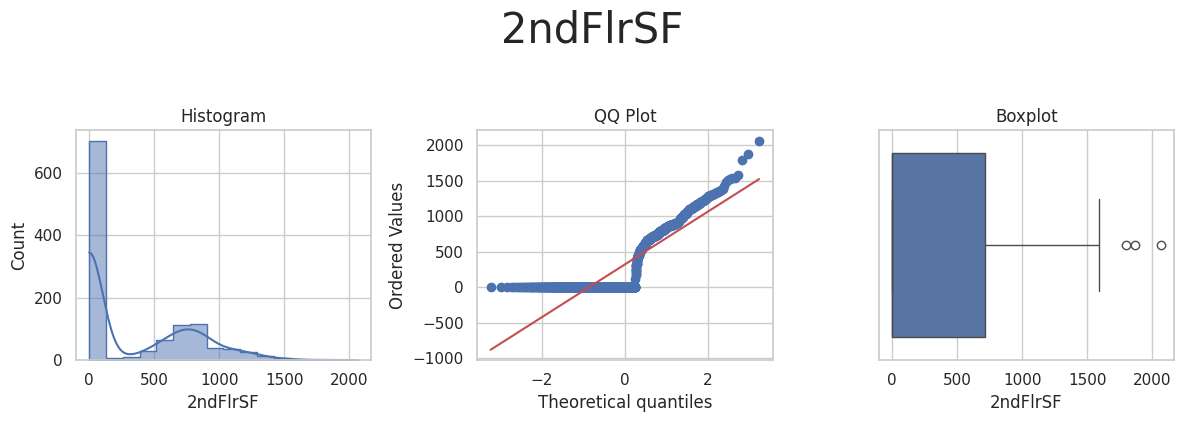

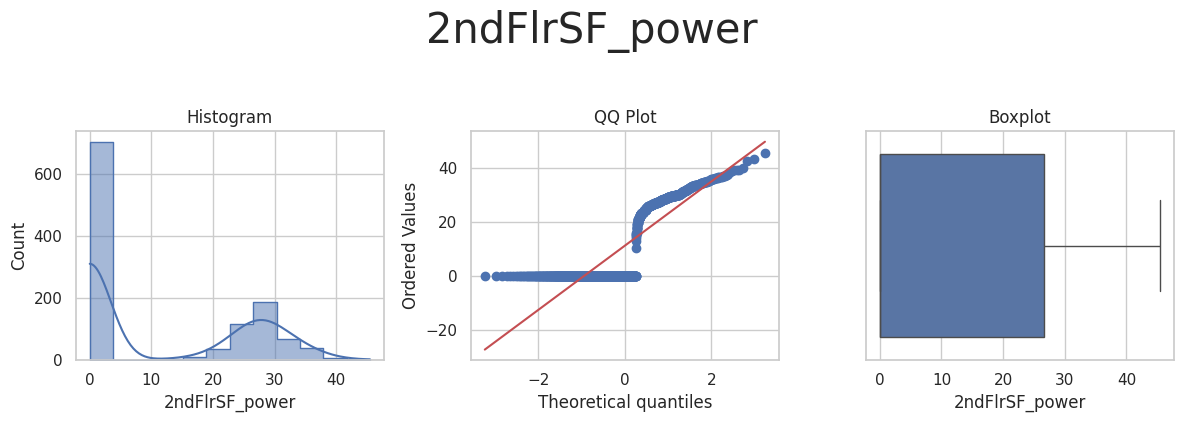

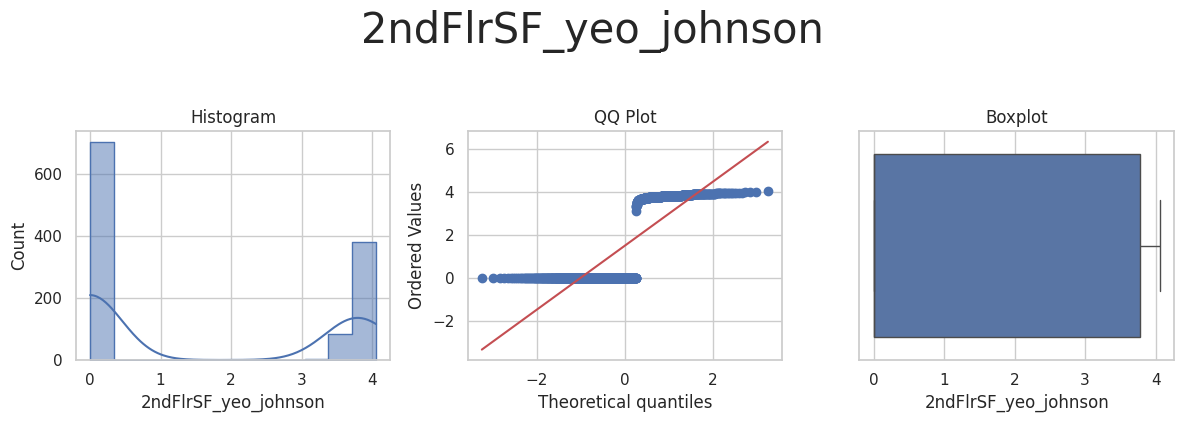



* Variable Analyzed: BedroomAbvGr
* Applied transformation: ['BedroomAbvGr_power', 'BedroomAbvGr_yeo_johnson'] 



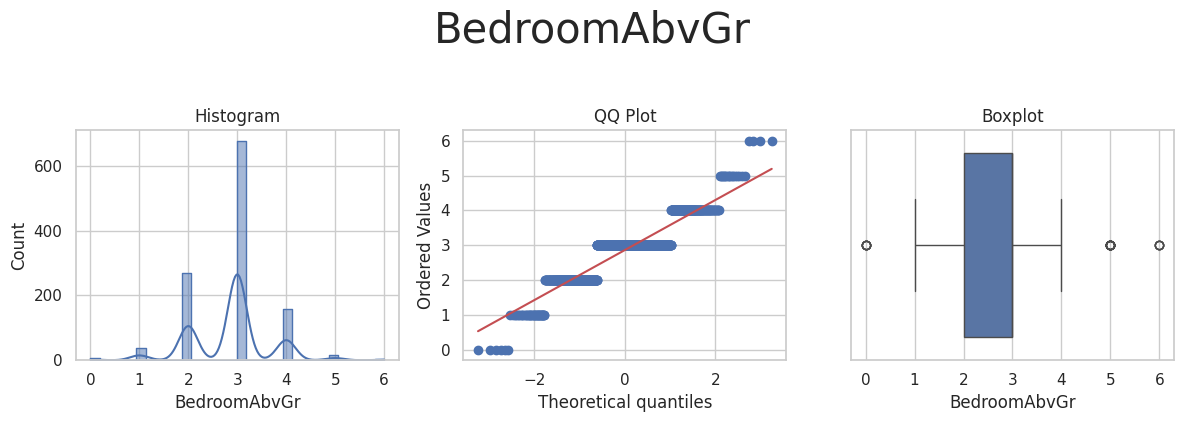

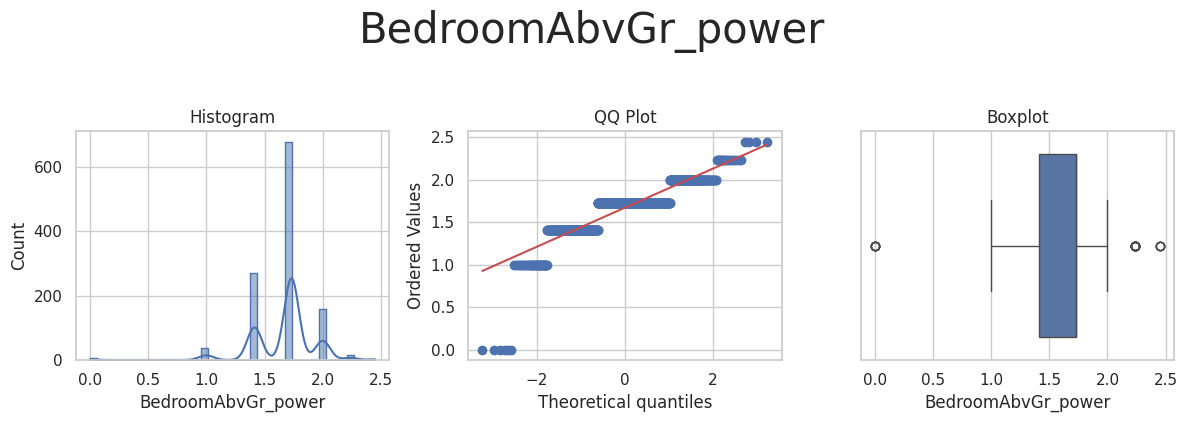

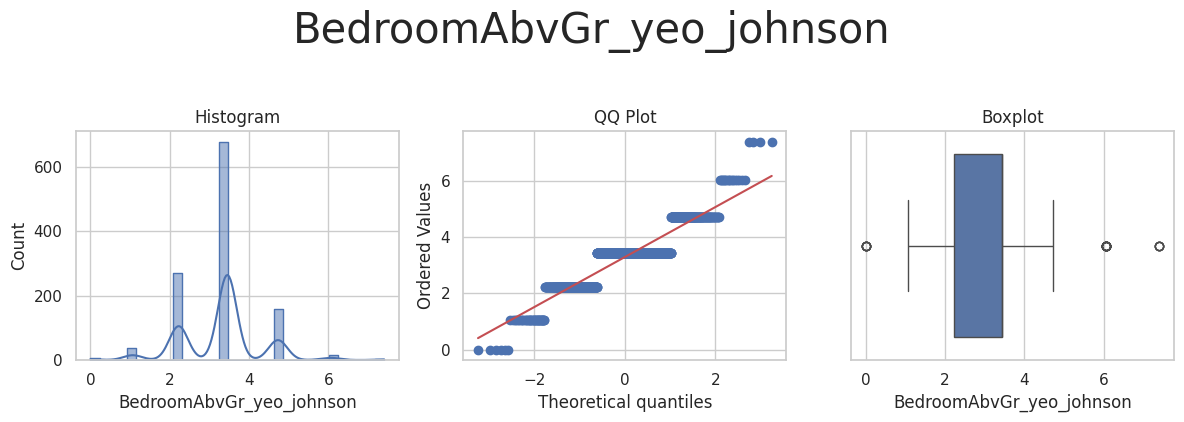



* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson'] 



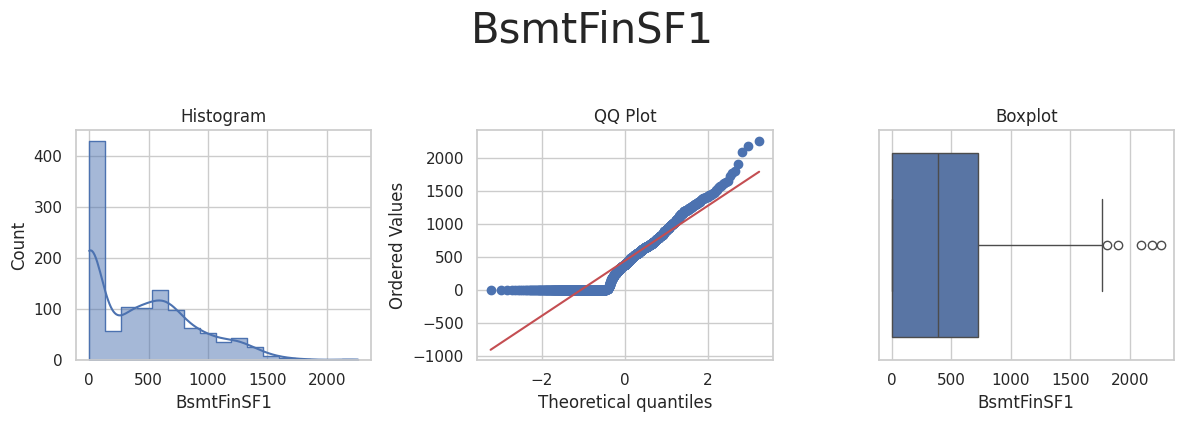

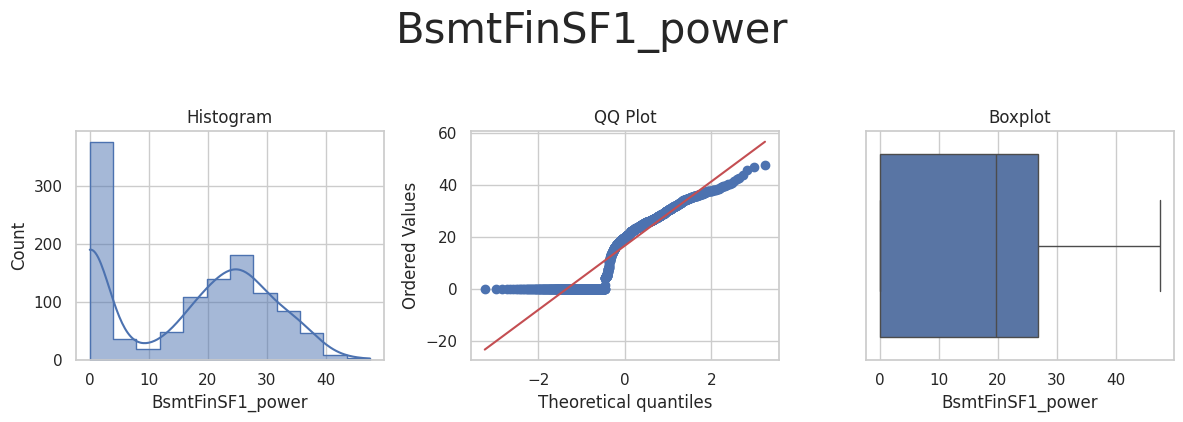

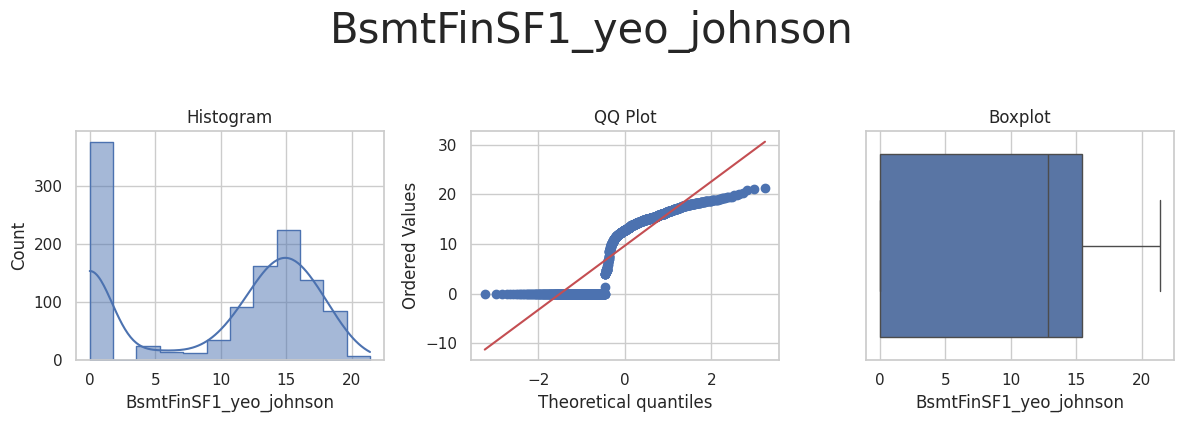



* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_power', 'BsmtUnfSF_yeo_johnson'] 



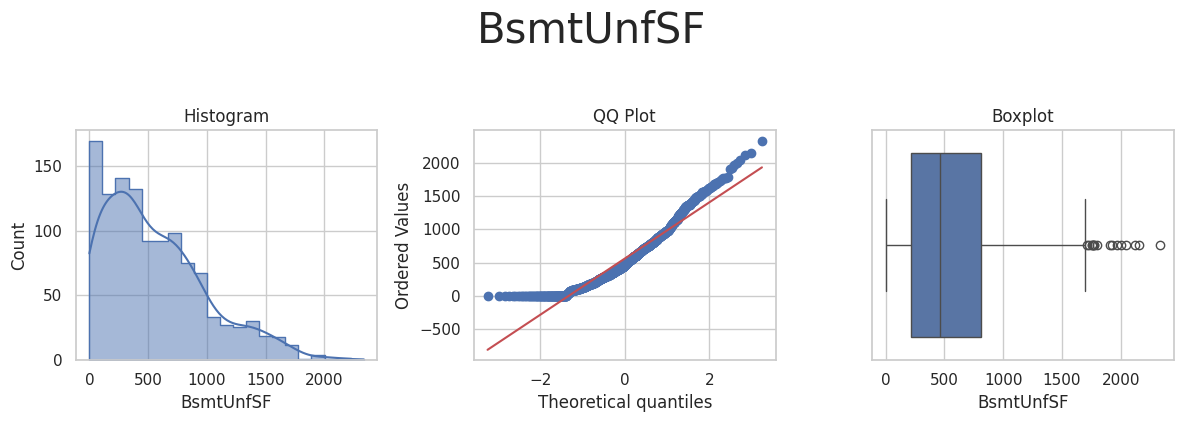

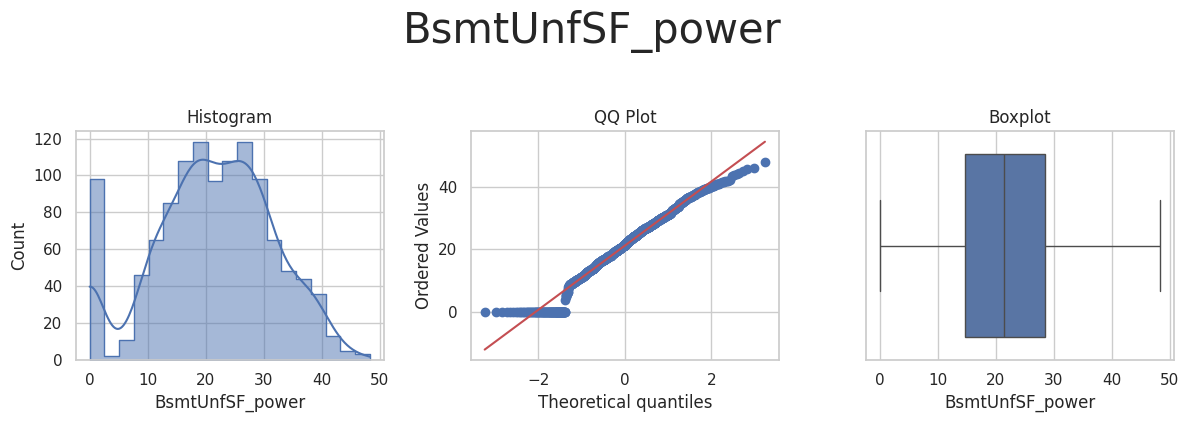

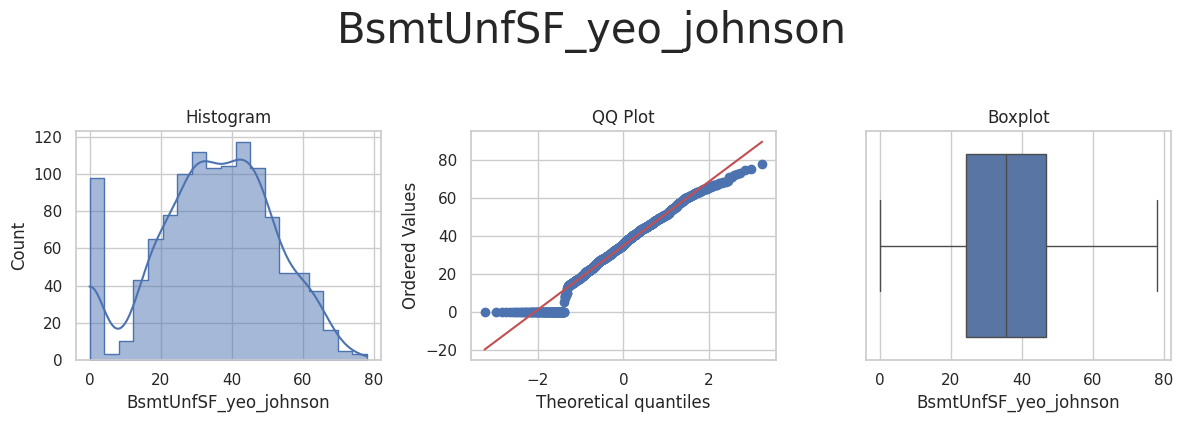



* Variable Analyzed: EnclosedPorch
* Applied transformation: ['EnclosedPorch_power', 'EnclosedPorch_yeo_johnson'] 



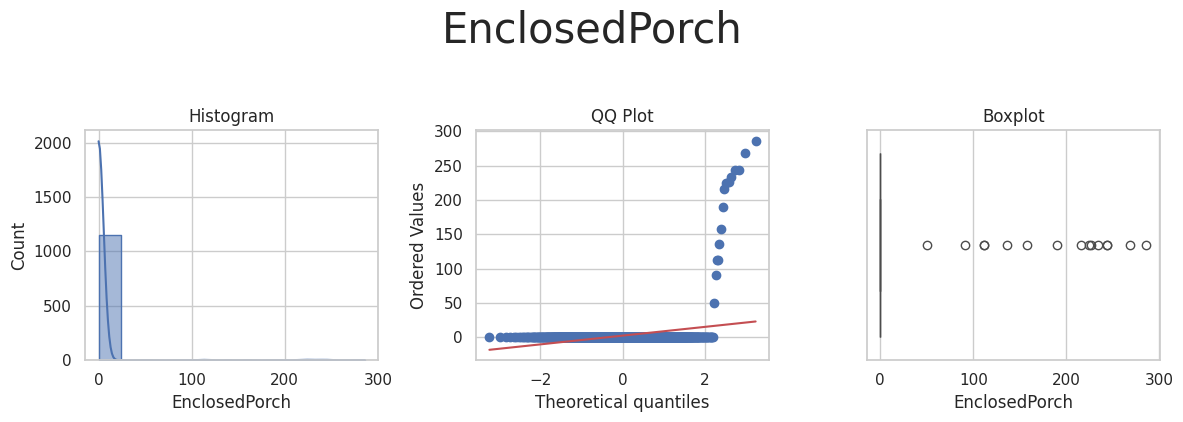

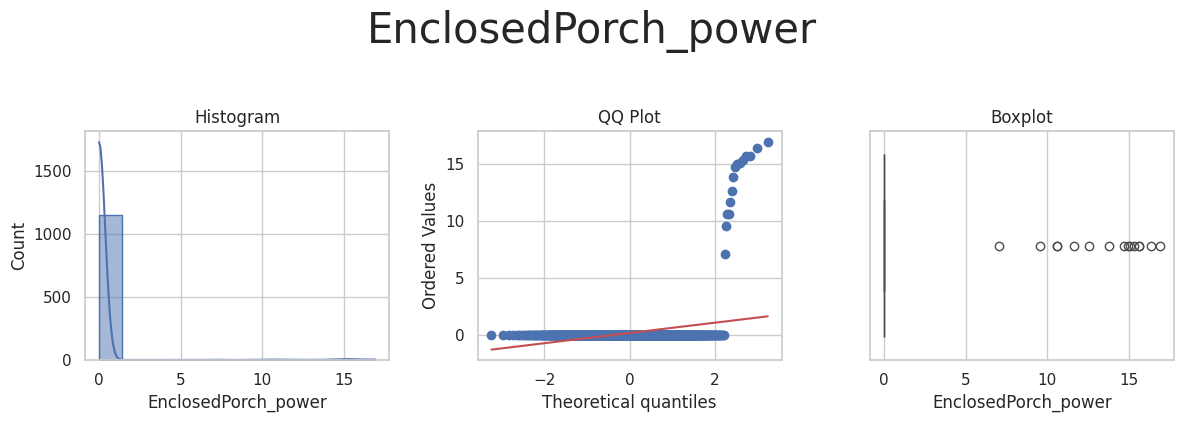

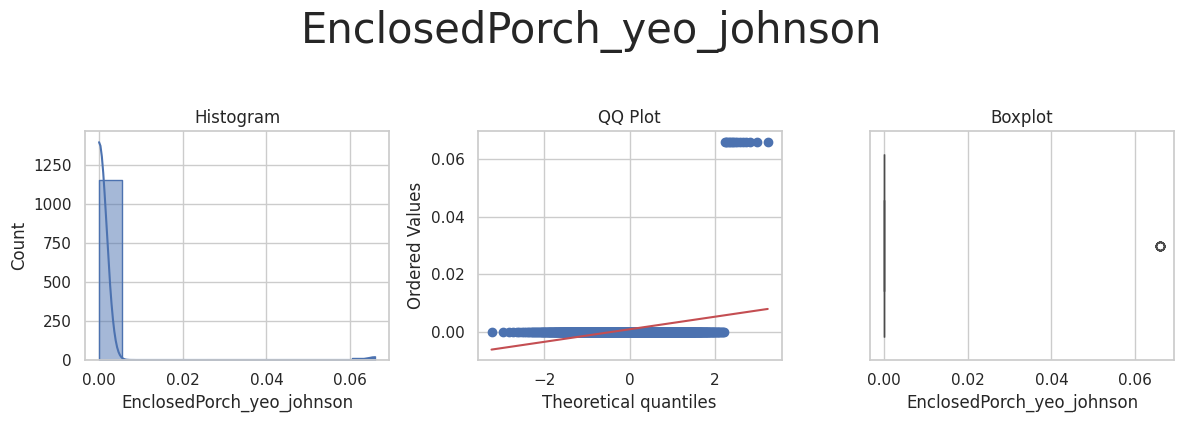



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



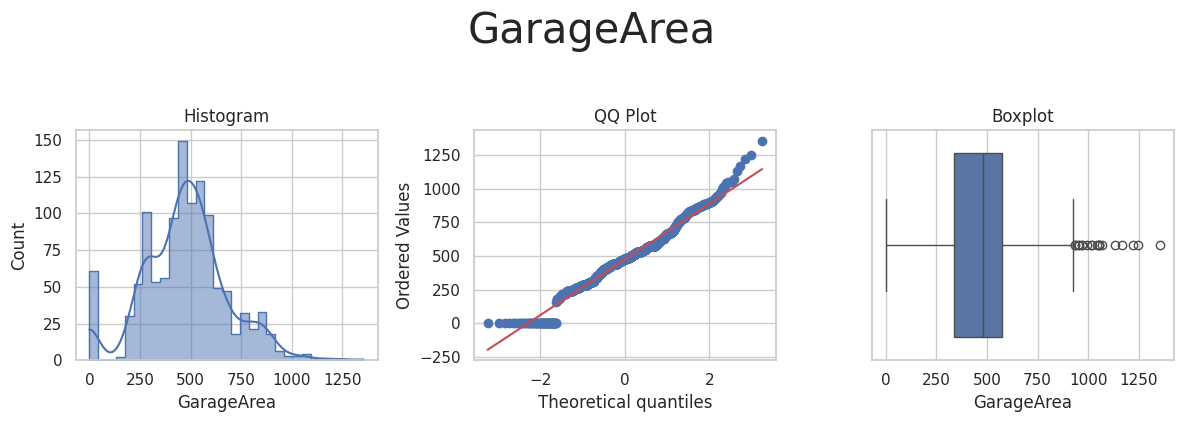

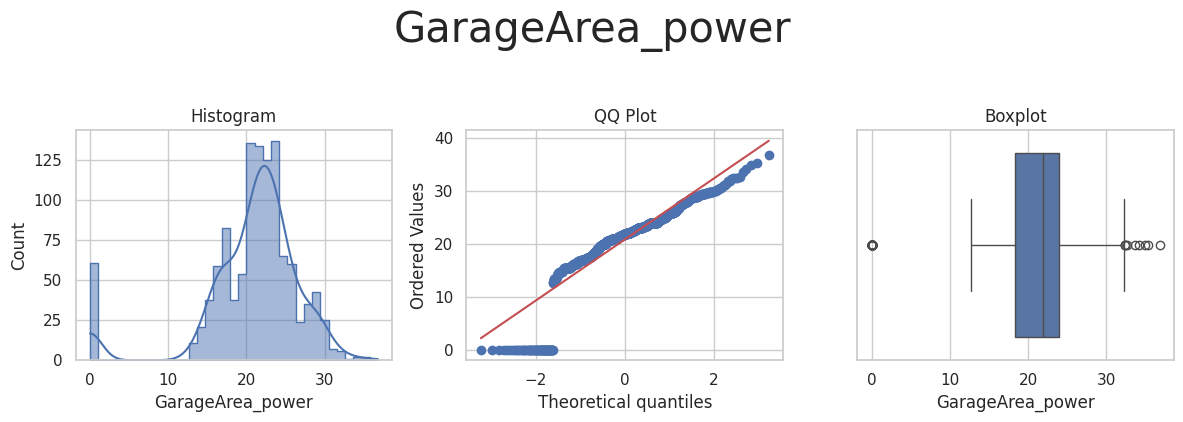

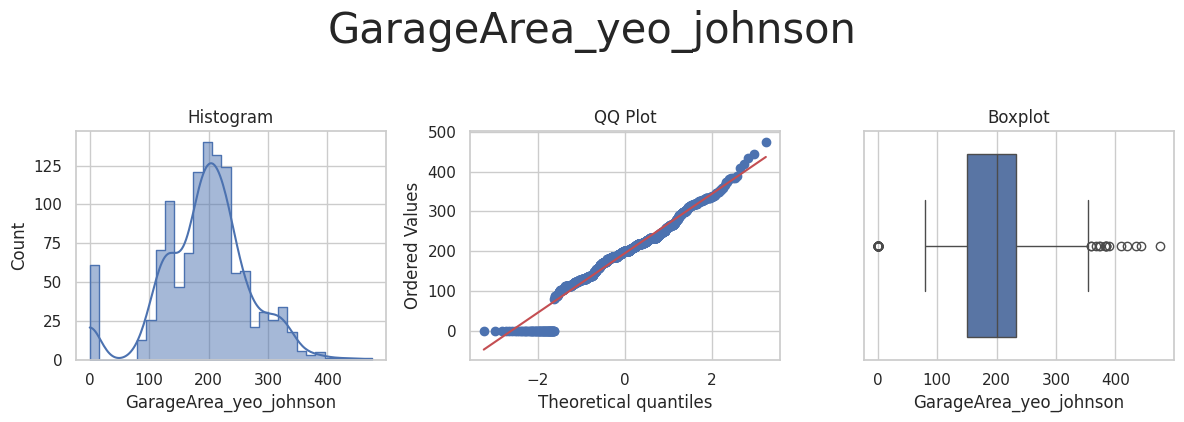



* Variable Analyzed: GarageYrBlt
* Applied transformation: ['GarageYrBlt_log_e', 'GarageYrBlt_log_10', 'GarageYrBlt_reciprocal', 'GarageYrBlt_power', 'GarageYrBlt_box_cox', 'GarageYrBlt_yeo_johnson'] 



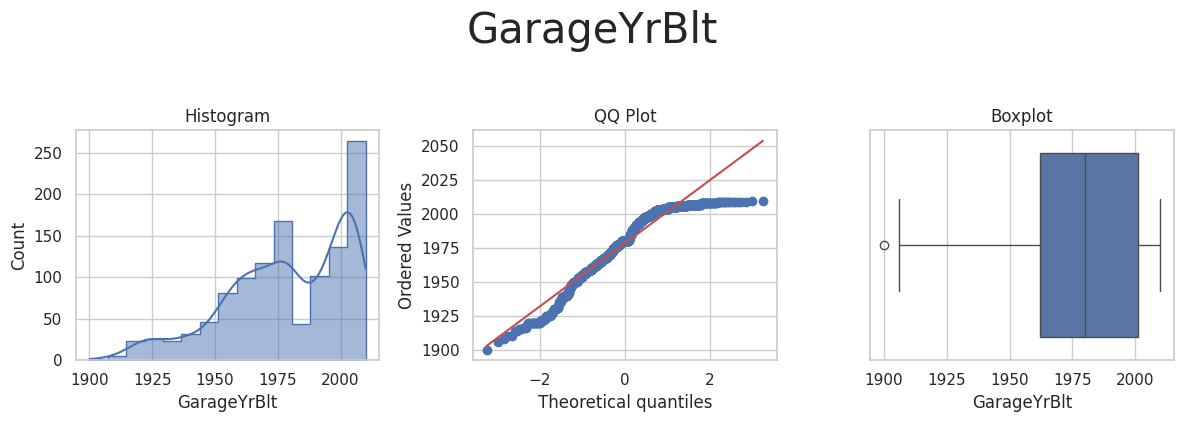

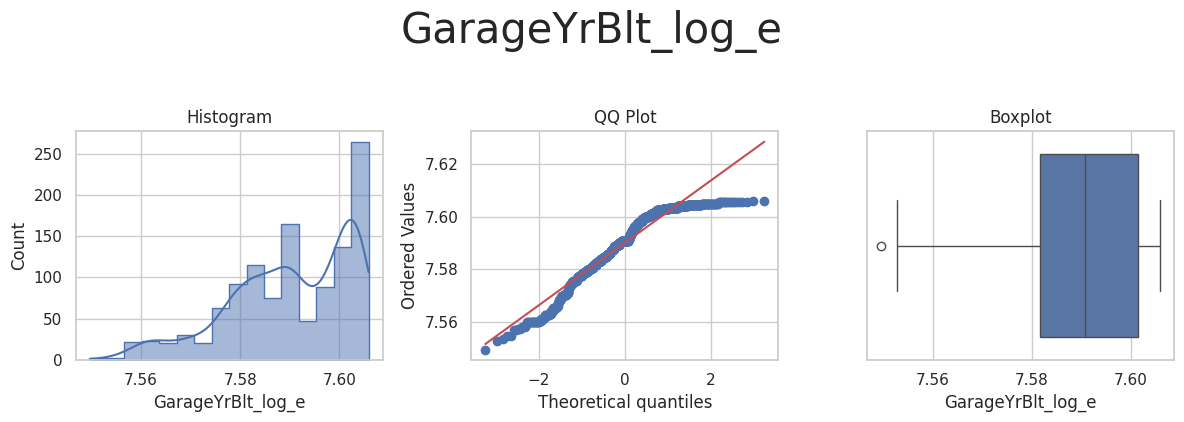

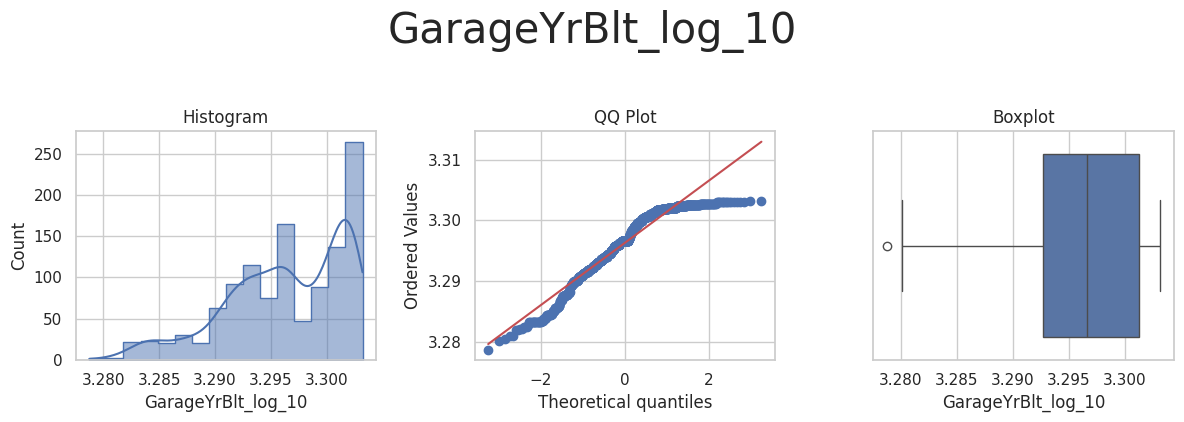

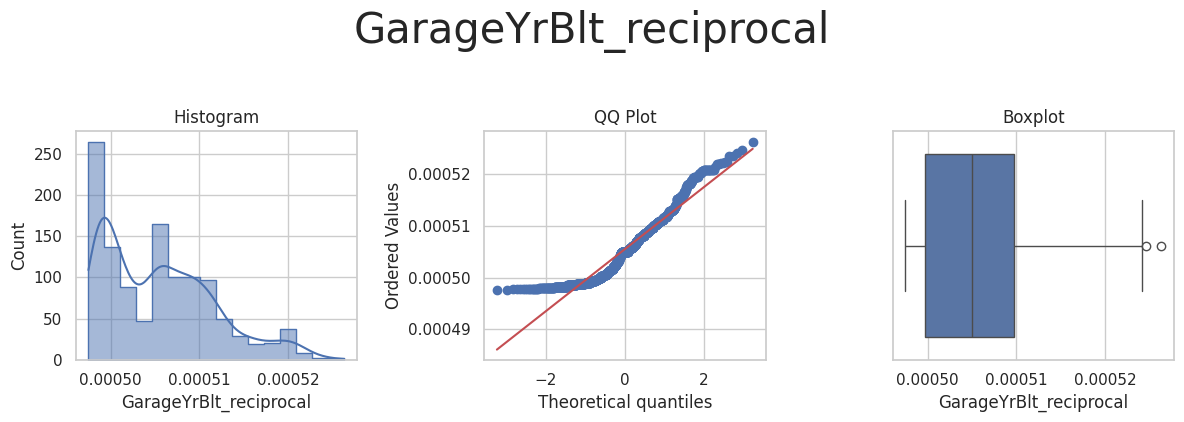

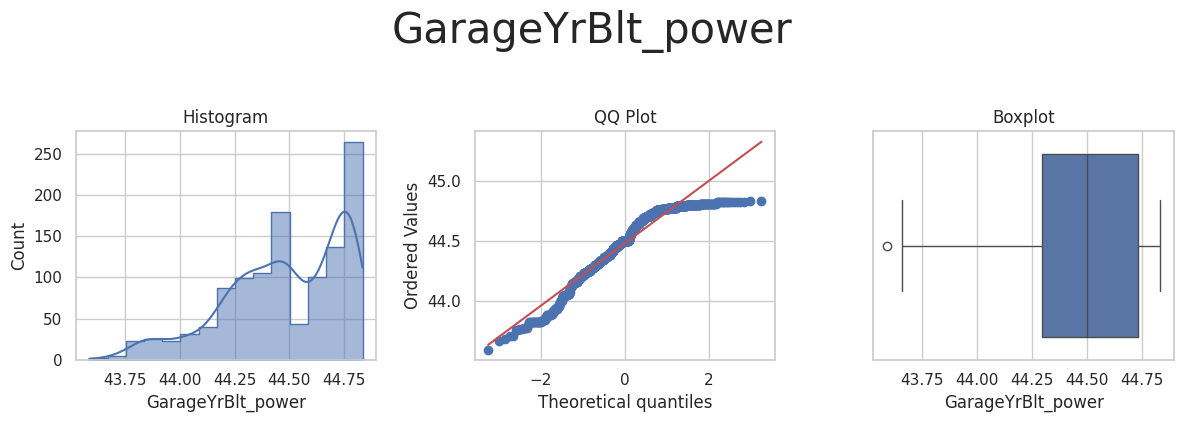

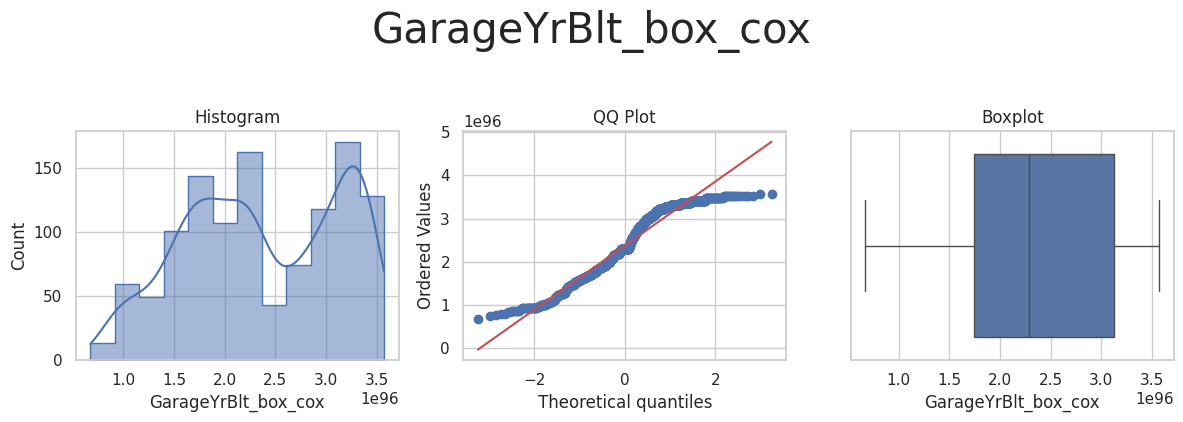

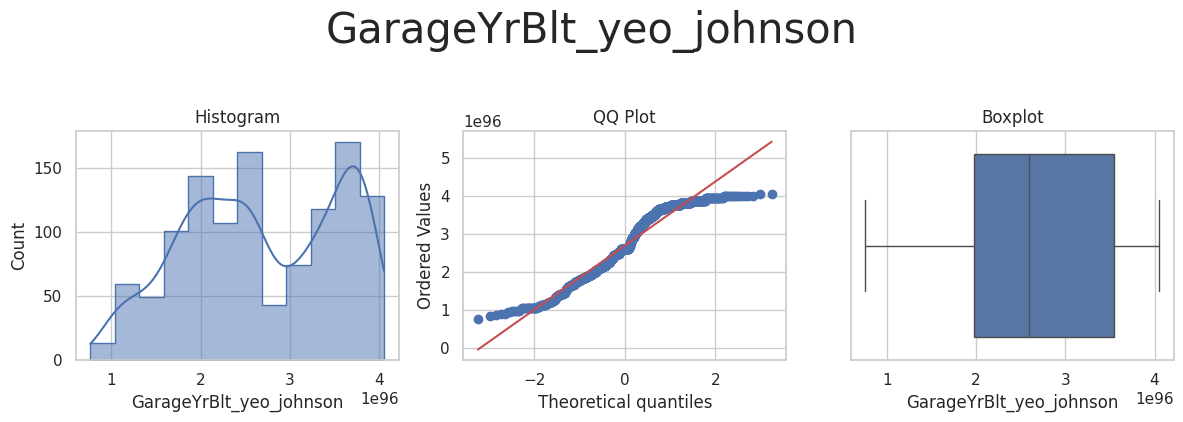



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



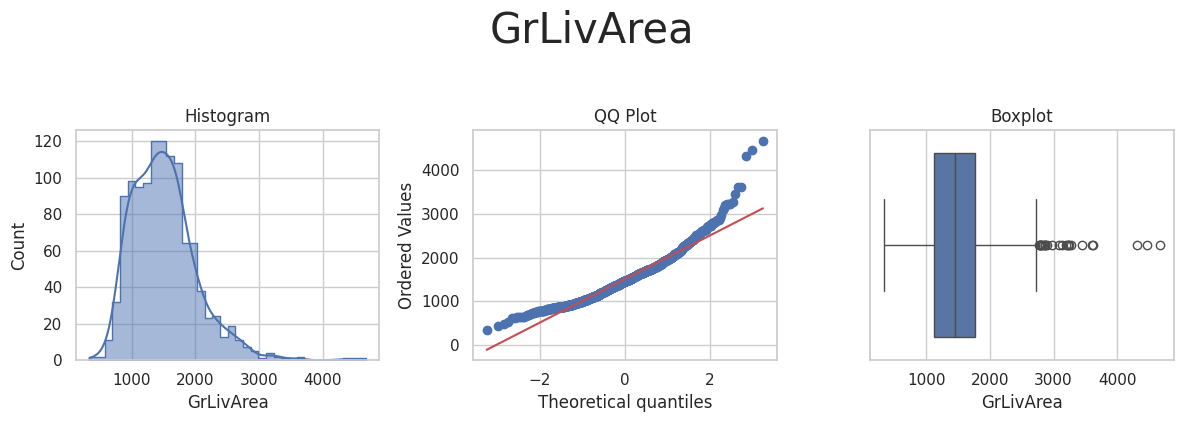

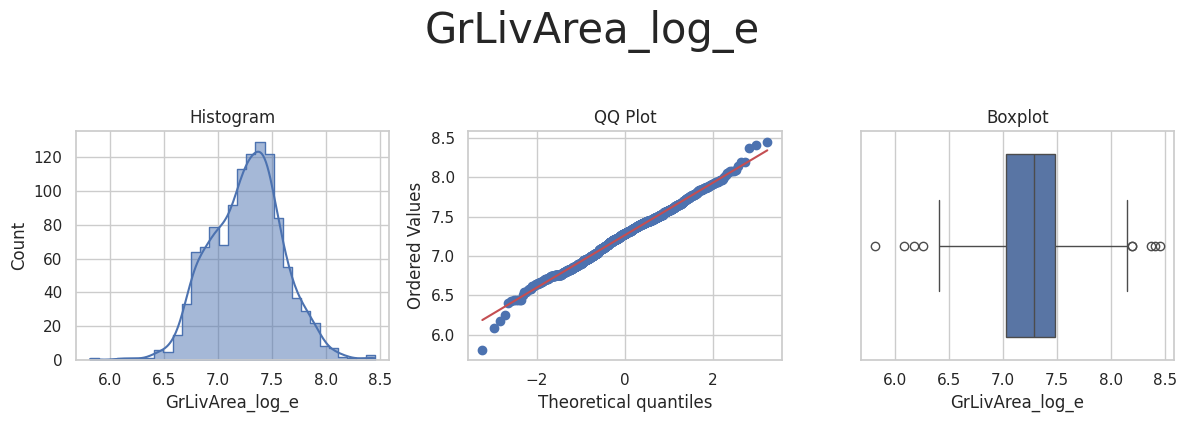

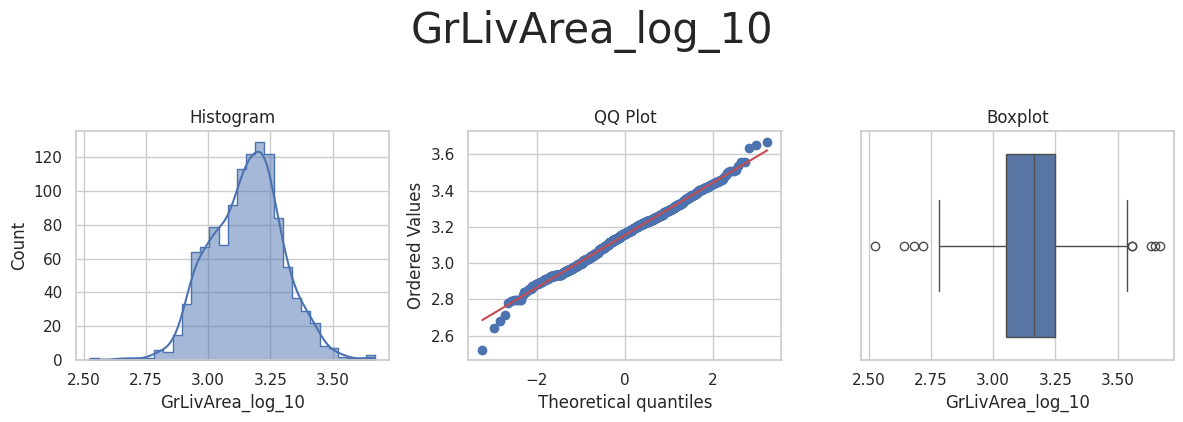

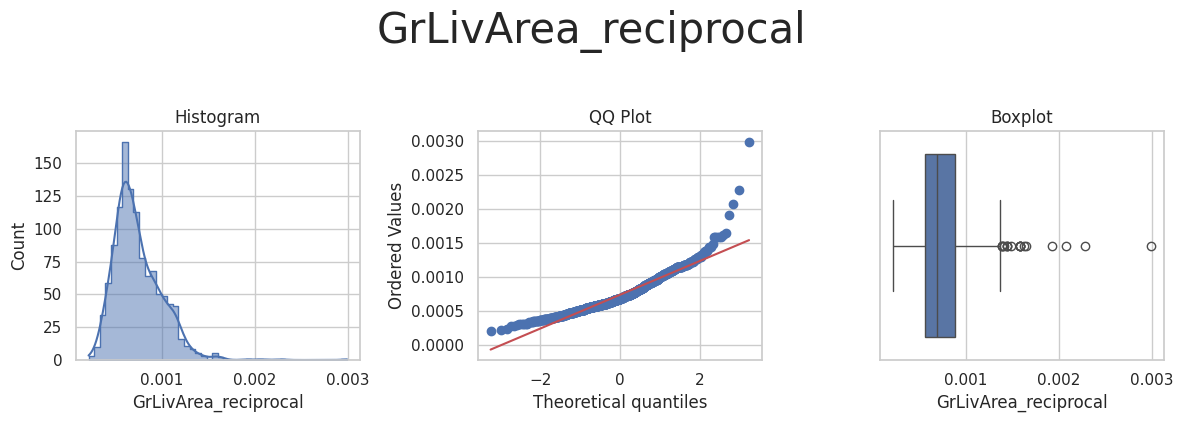

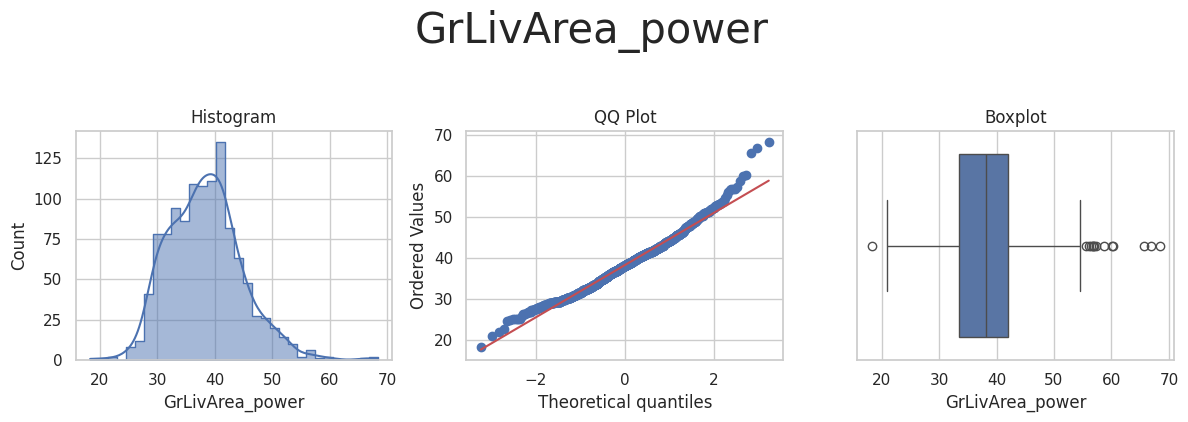

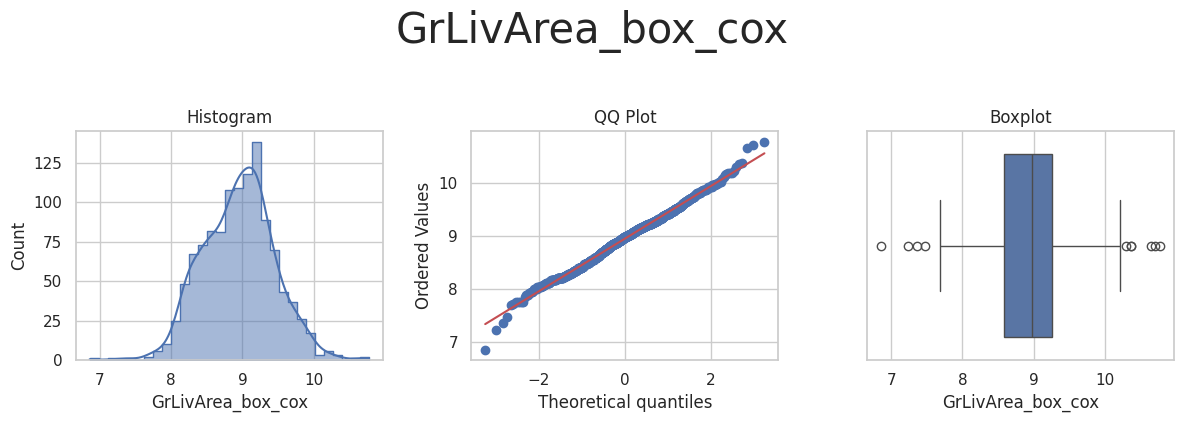

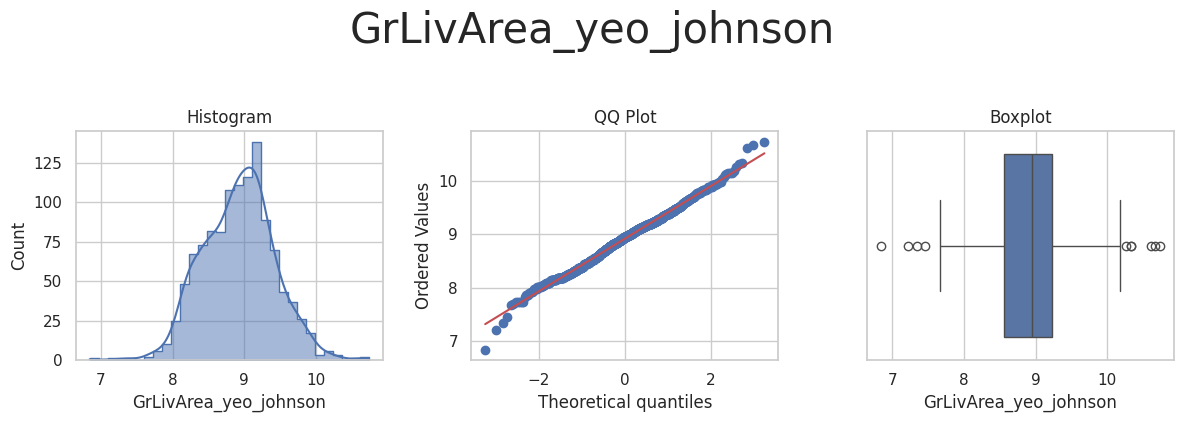



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



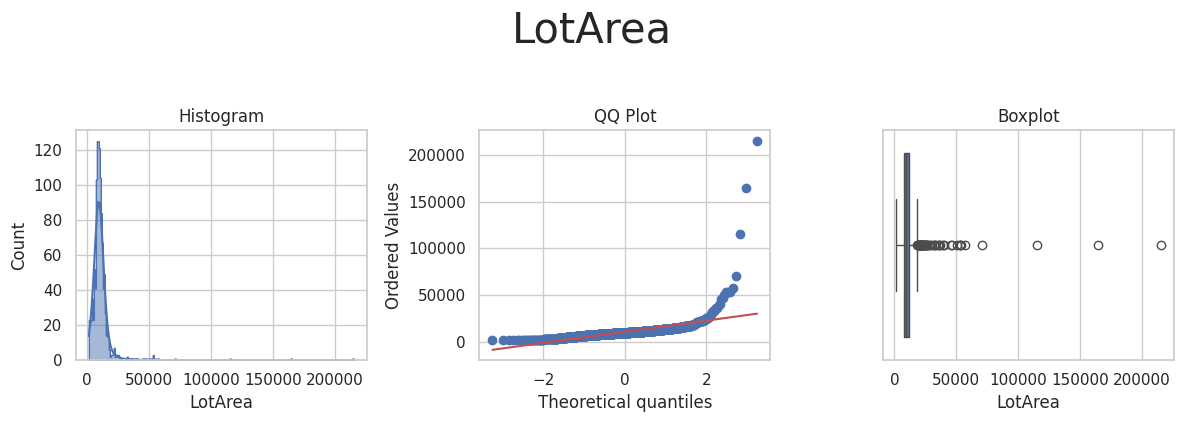

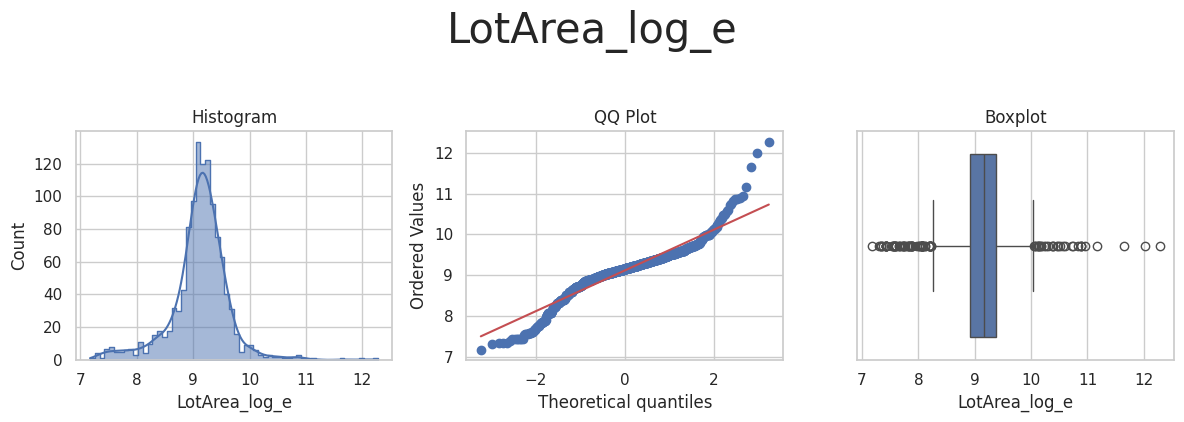

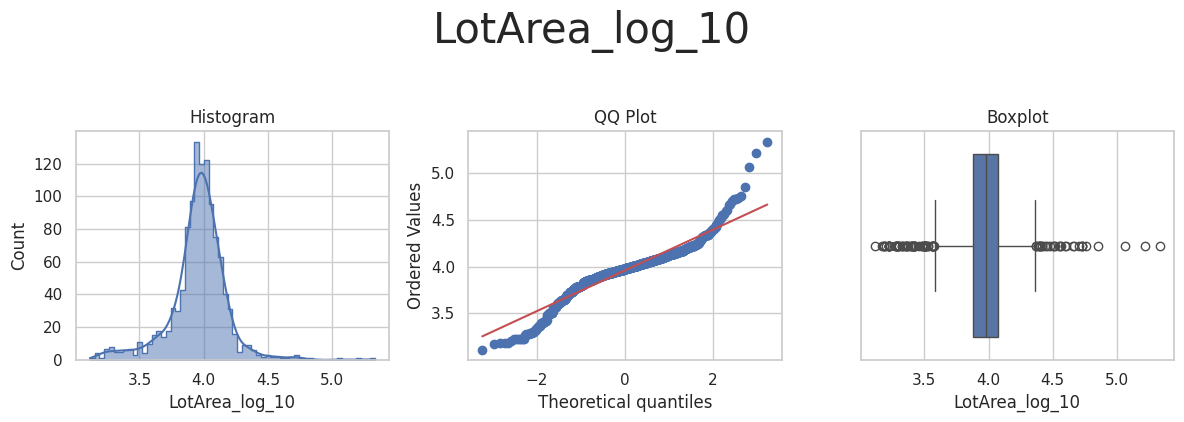

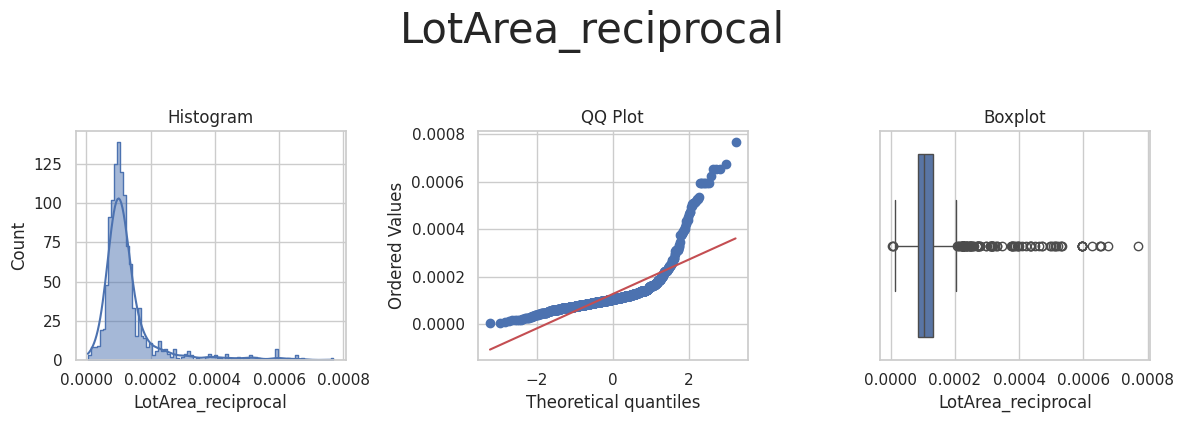

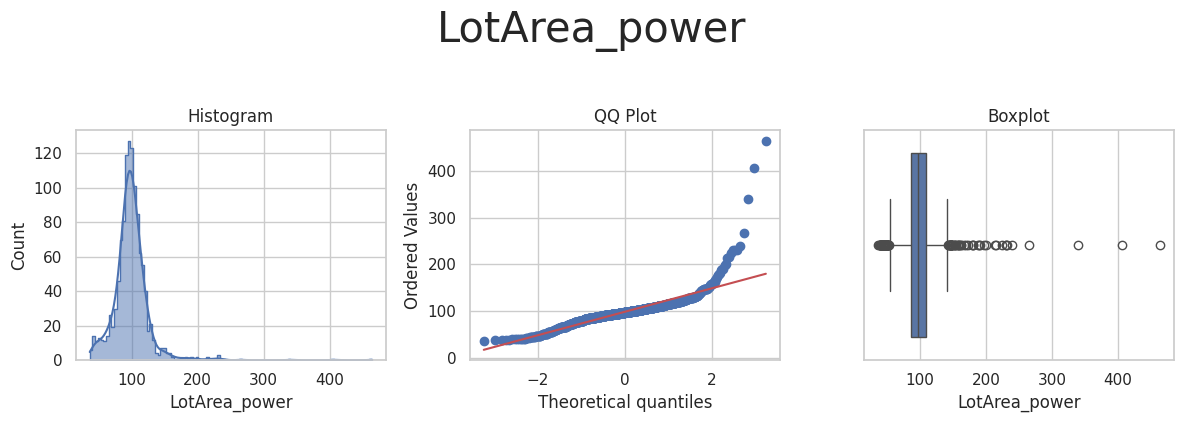

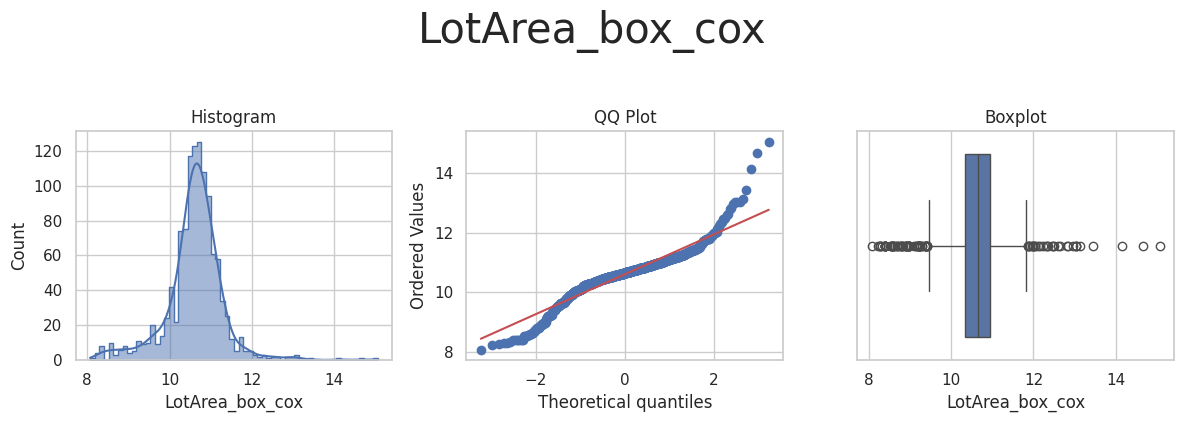

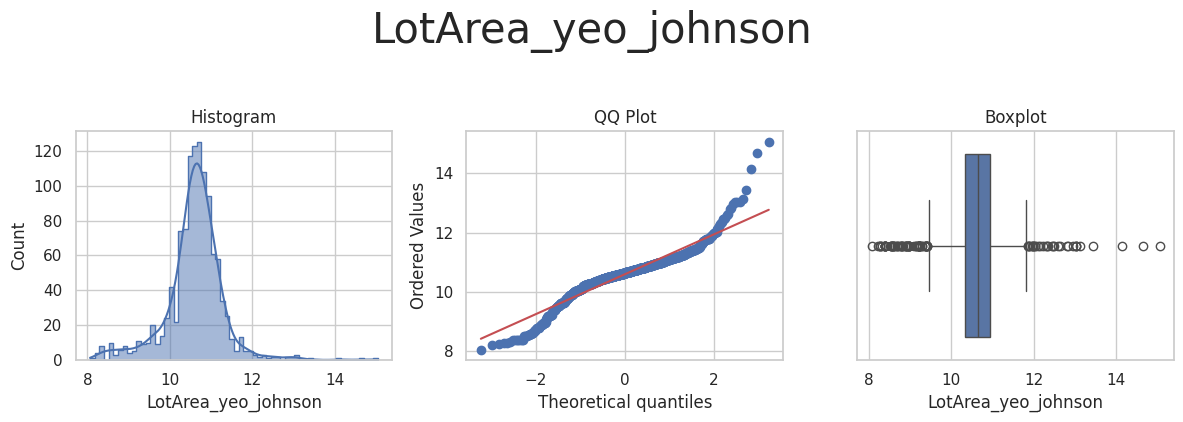



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



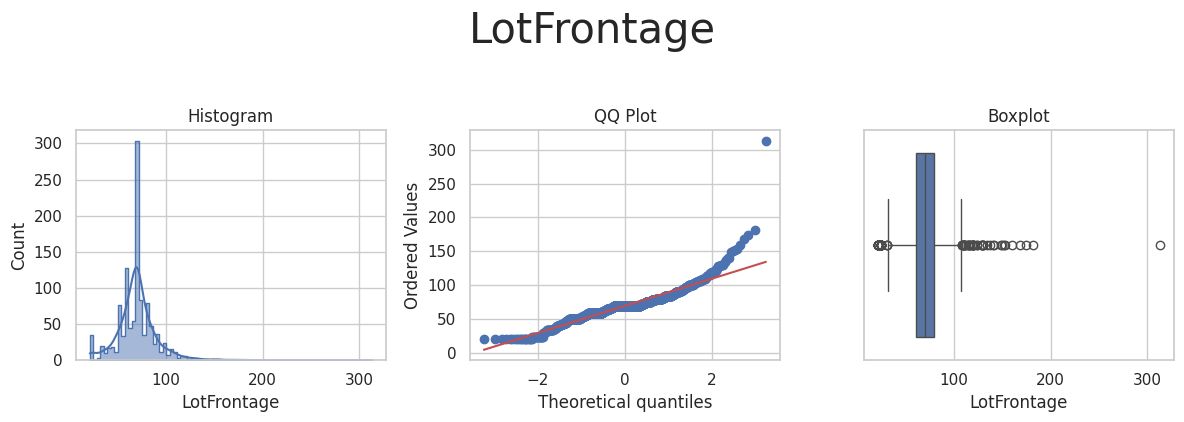

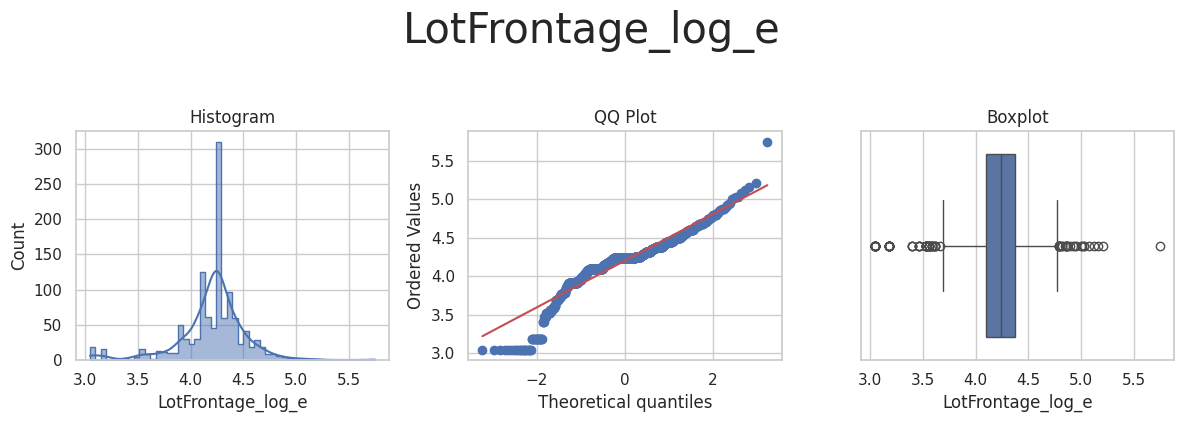

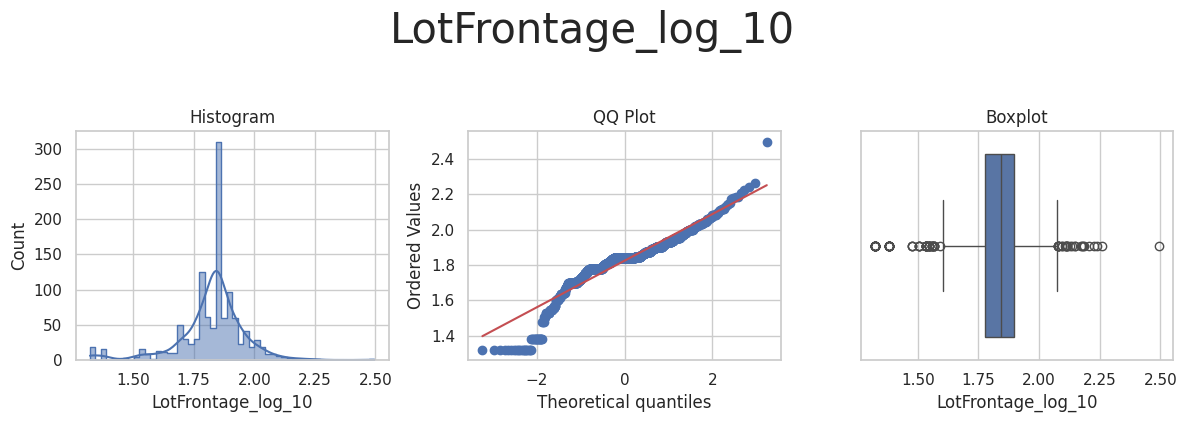

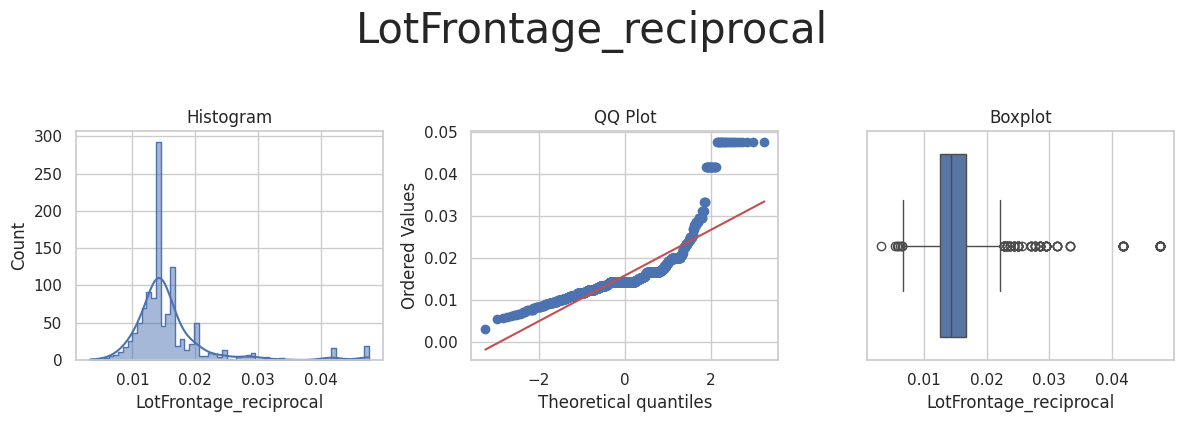

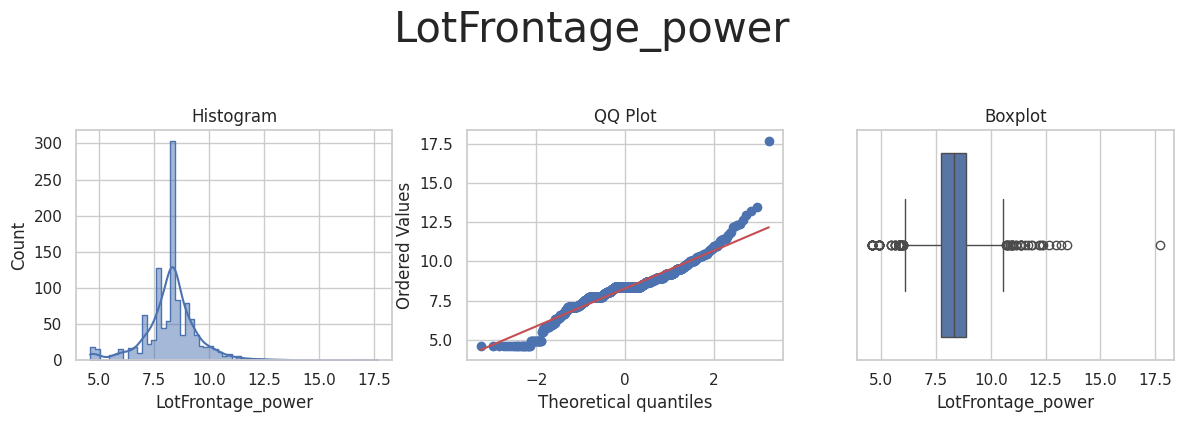

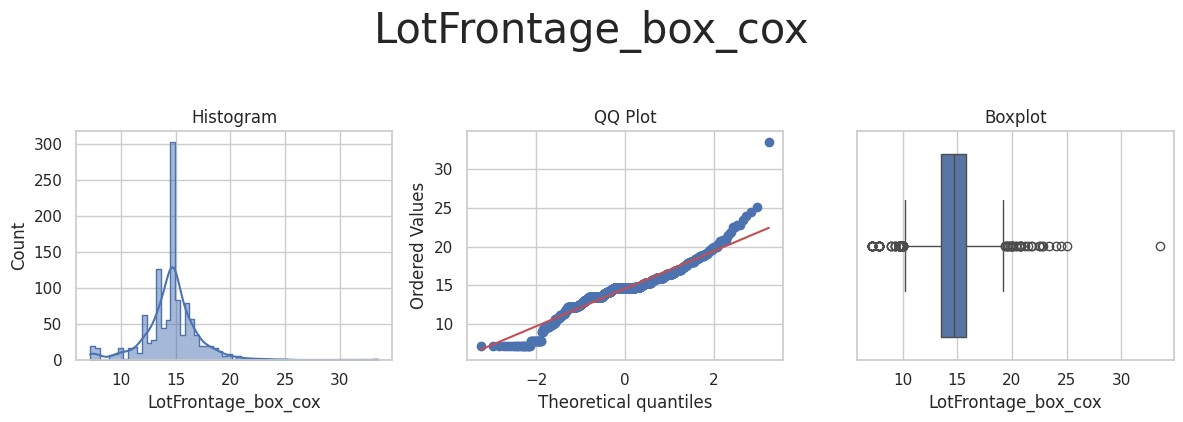

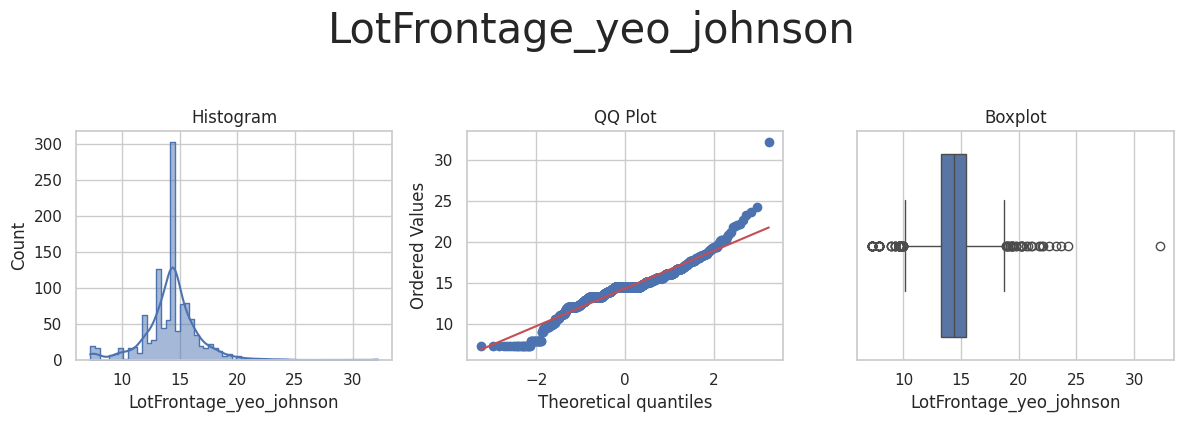



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



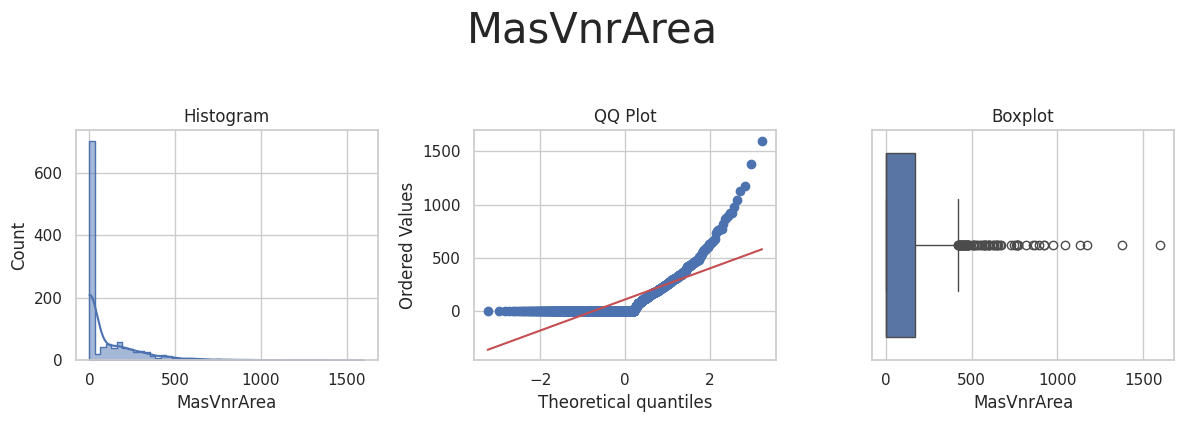

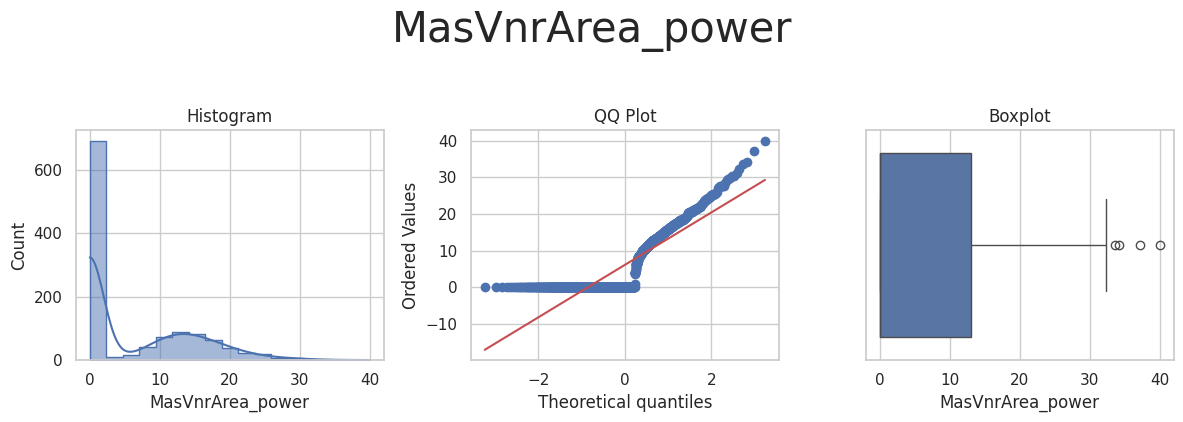

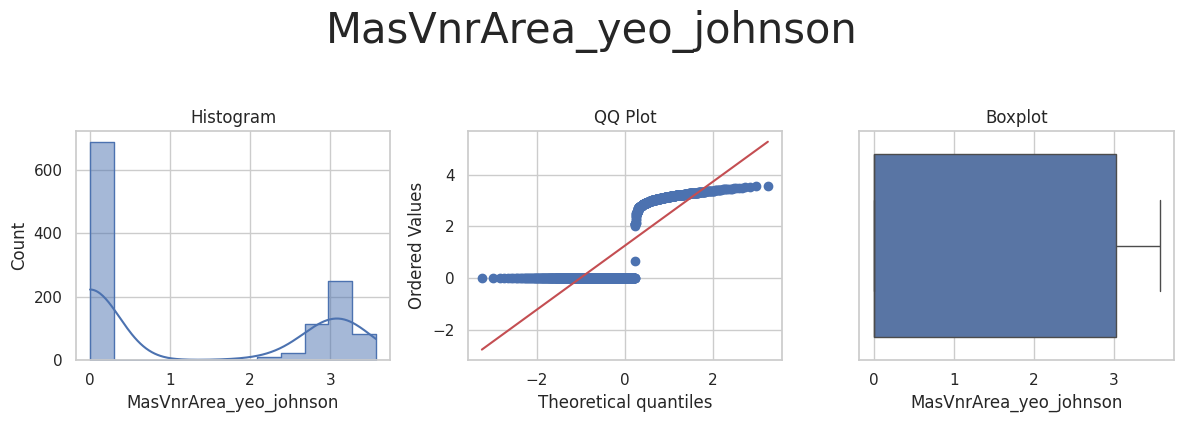



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



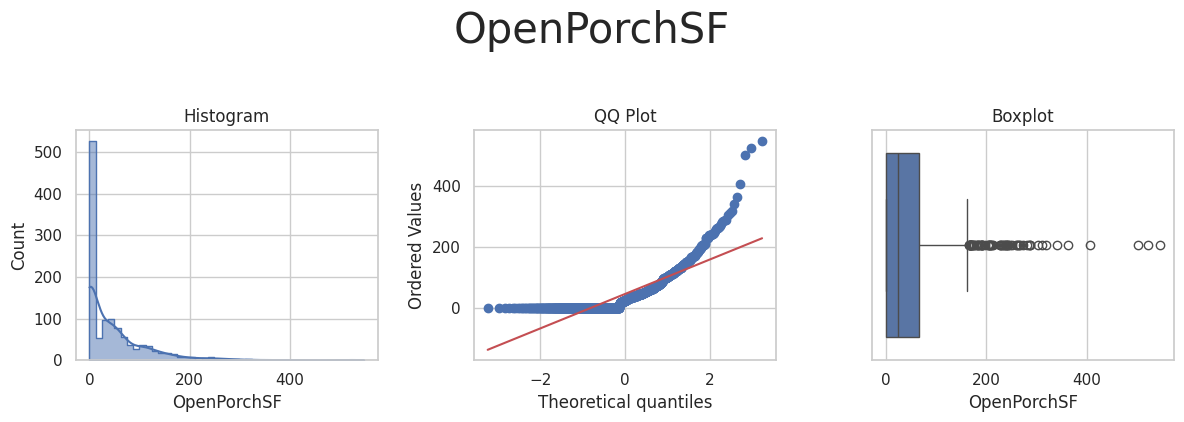

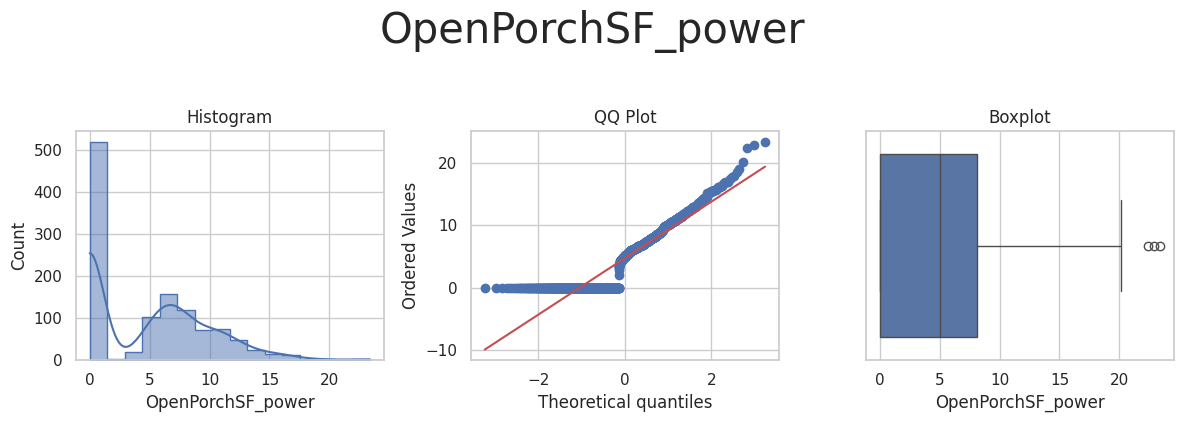

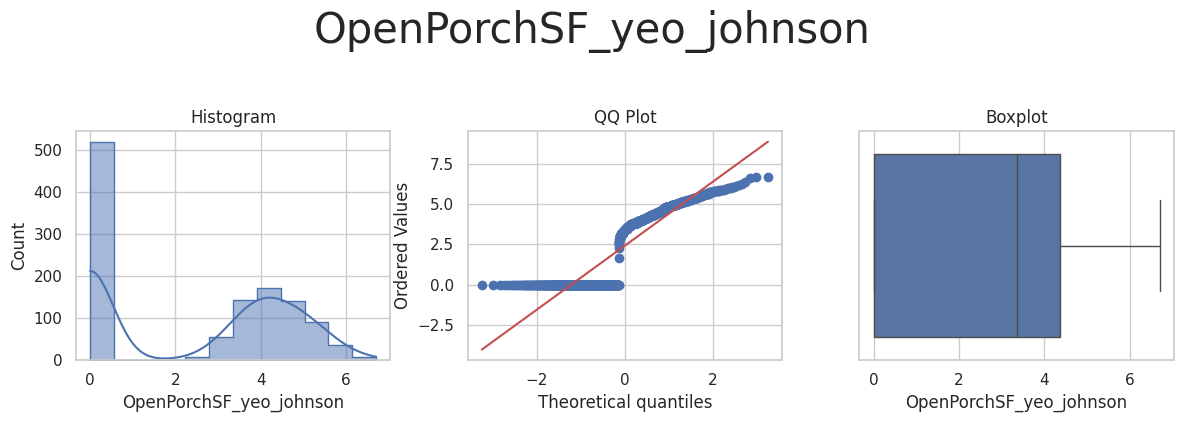



* Variable Analyzed: OverallCond
* Applied transformation: ['OverallCond_log_e', 'OverallCond_log_10', 'OverallCond_reciprocal', 'OverallCond_power', 'OverallCond_box_cox', 'OverallCond_yeo_johnson'] 



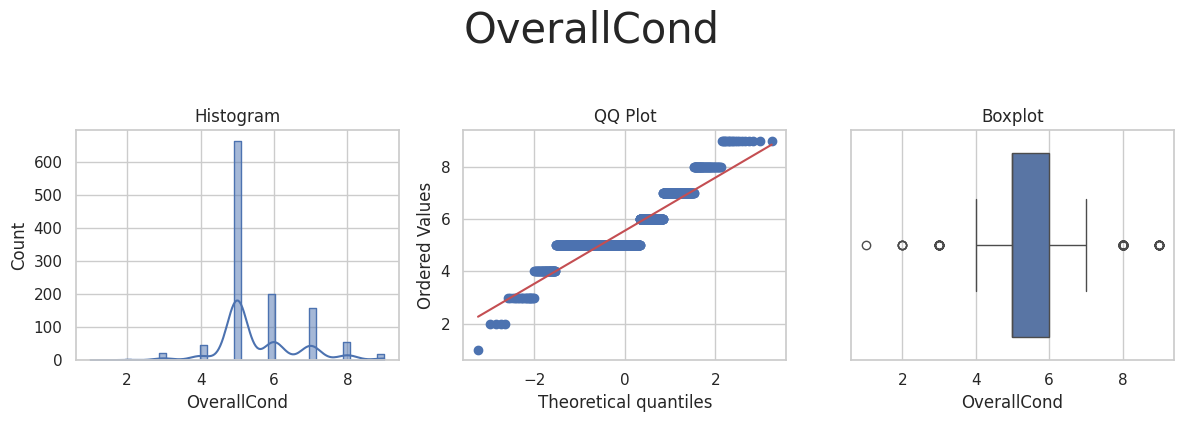

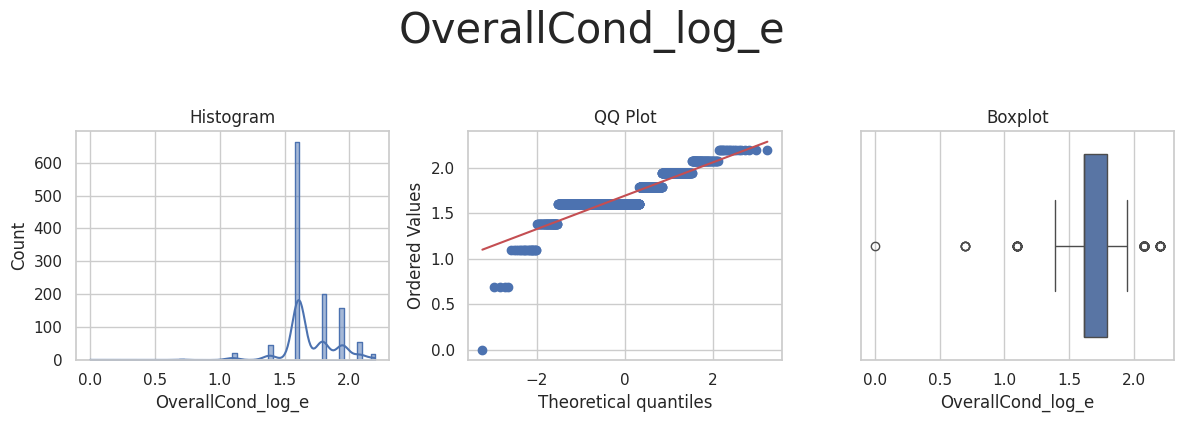

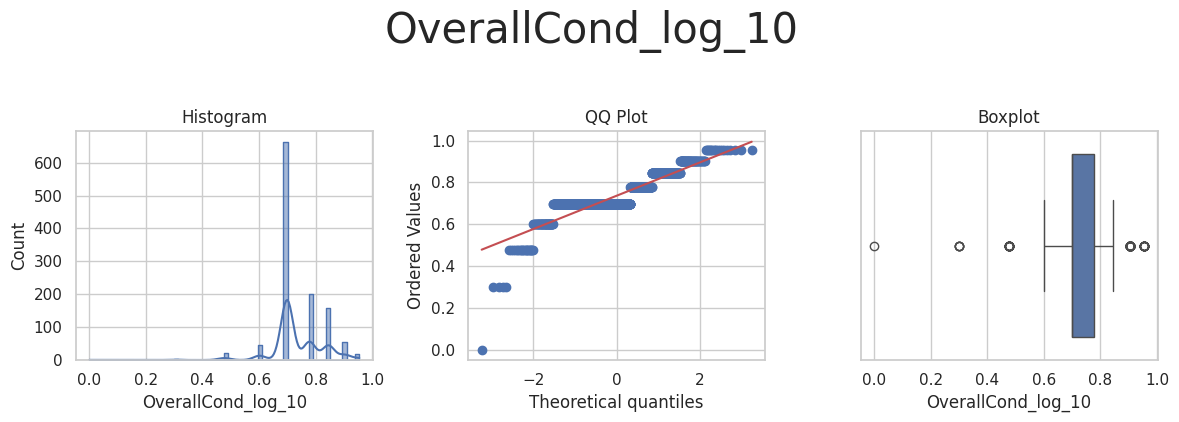

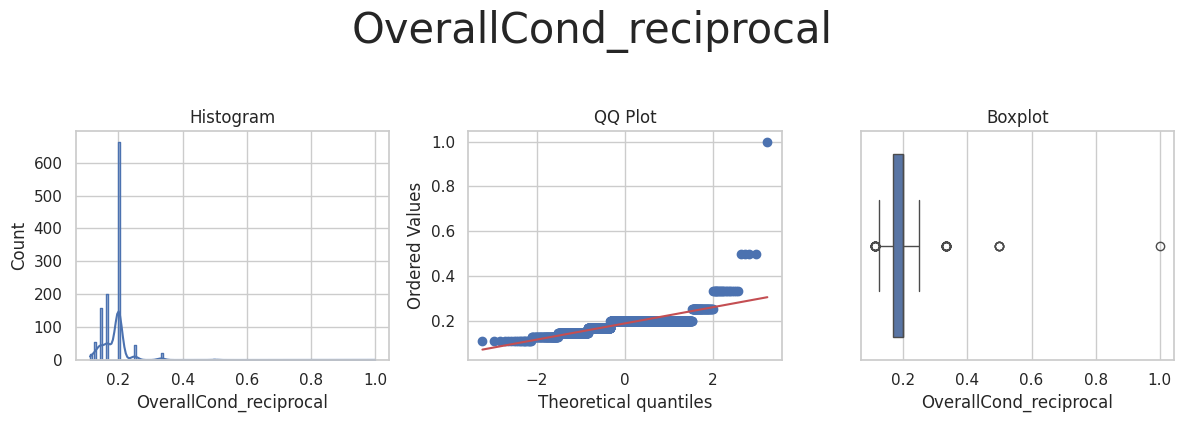

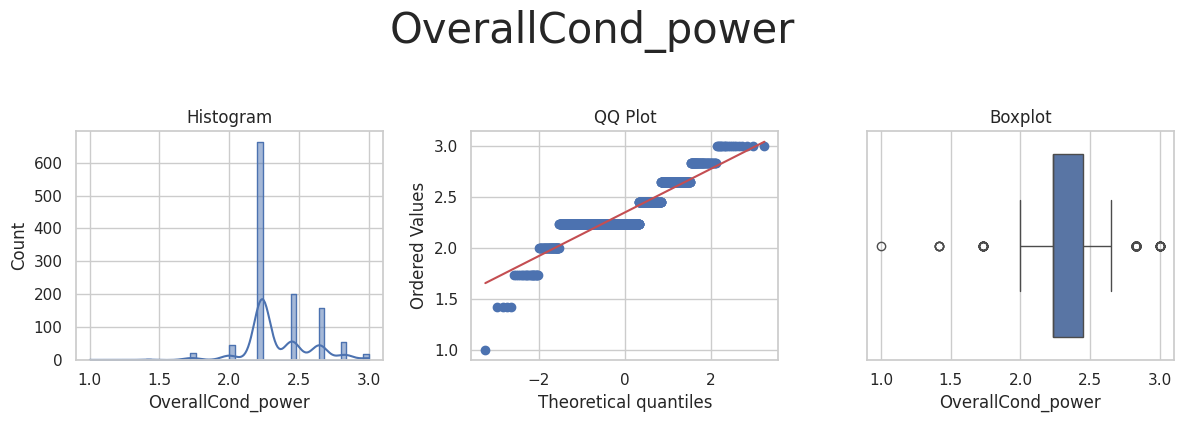

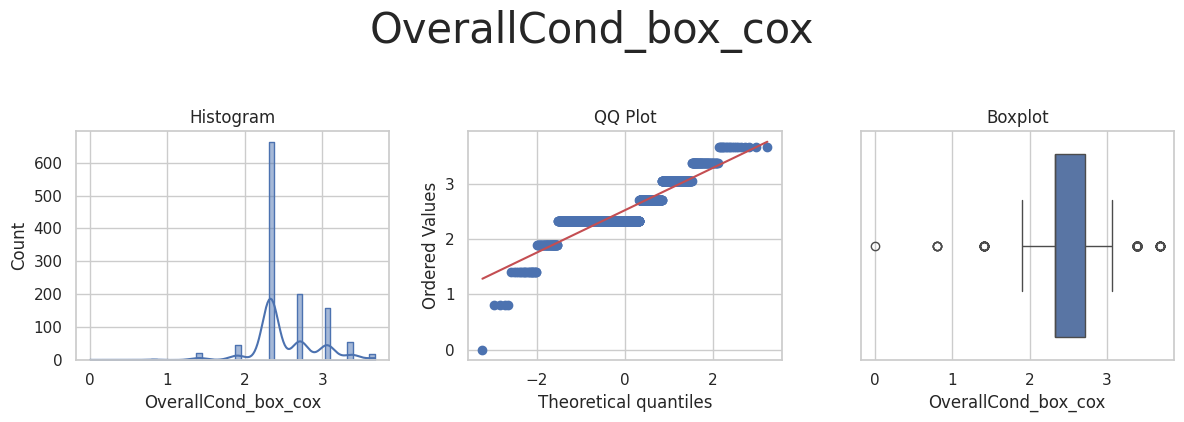

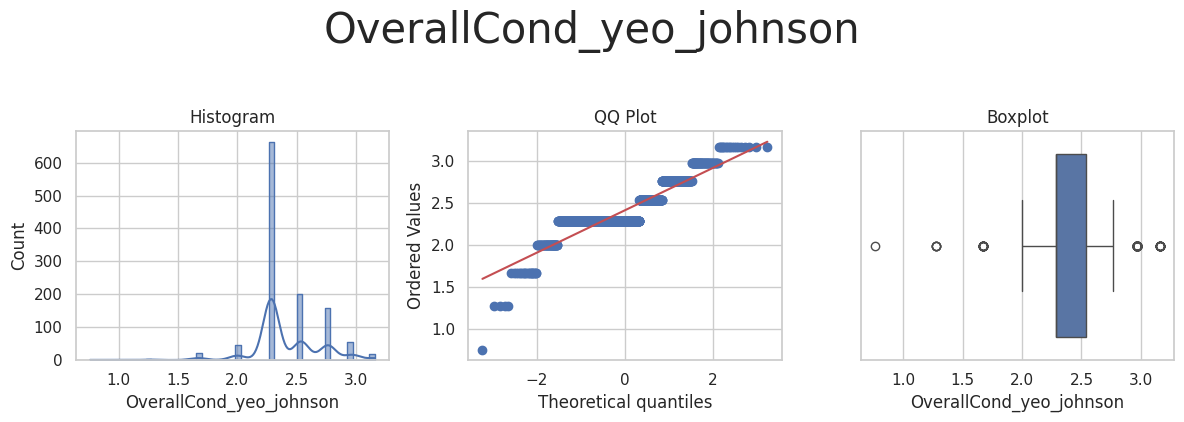



* Variable Analyzed: OverallQual
* Applied transformation: ['OverallQual_log_e', 'OverallQual_log_10', 'OverallQual_reciprocal', 'OverallQual_power', 'OverallQual_box_cox', 'OverallQual_yeo_johnson'] 



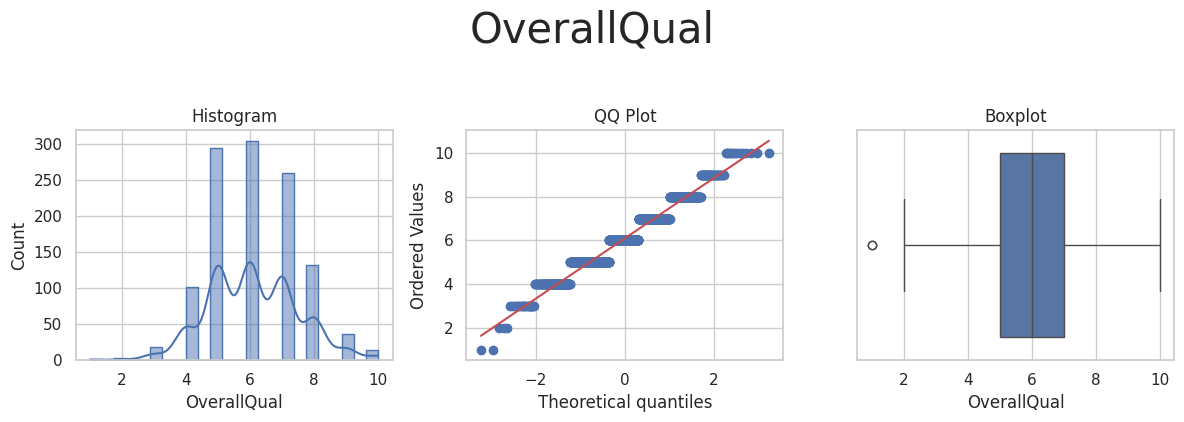

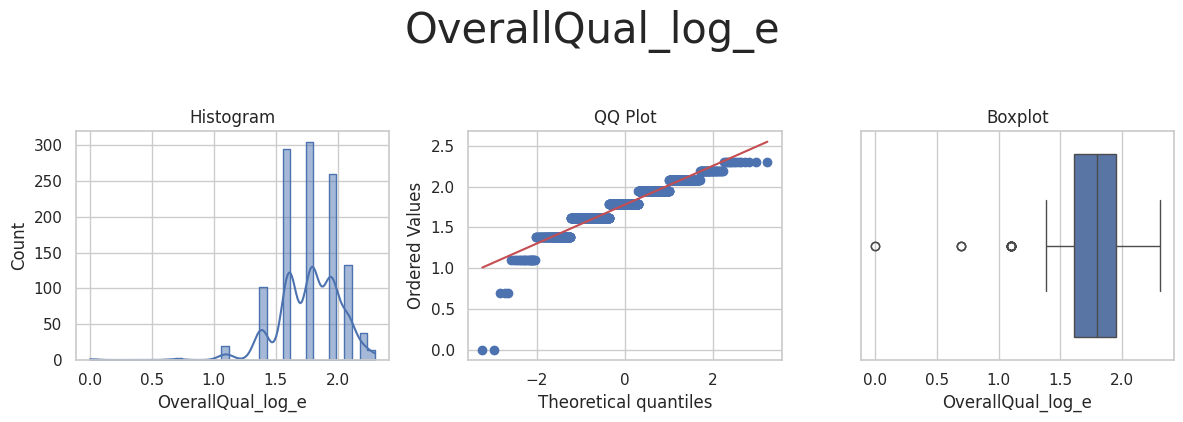

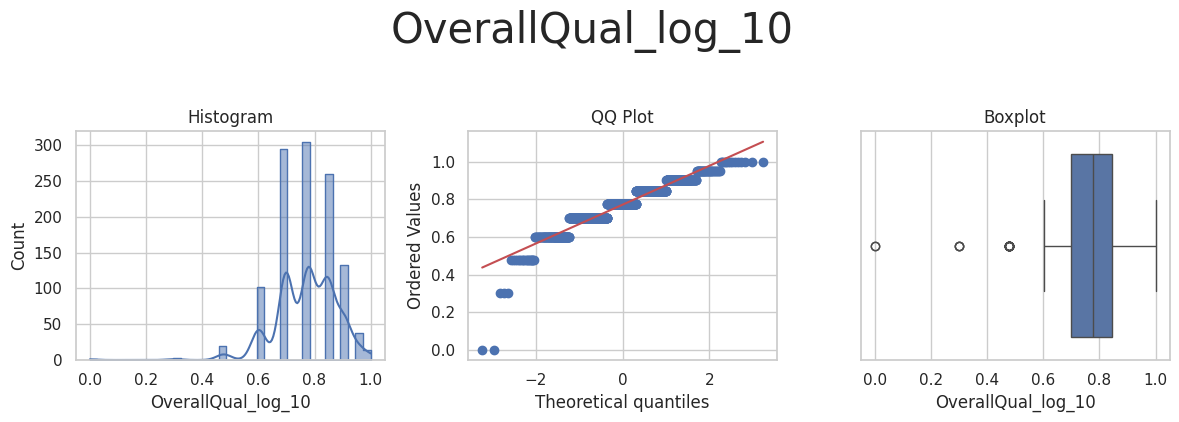

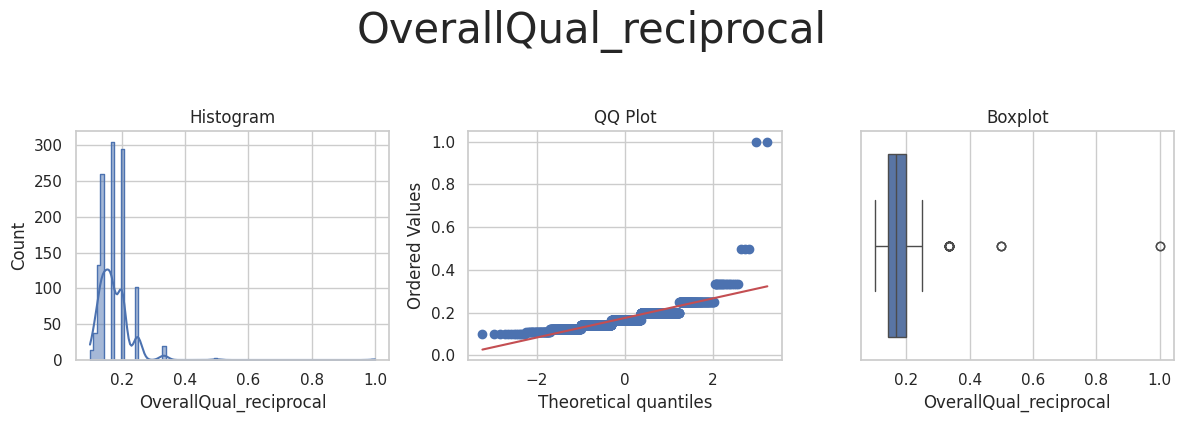

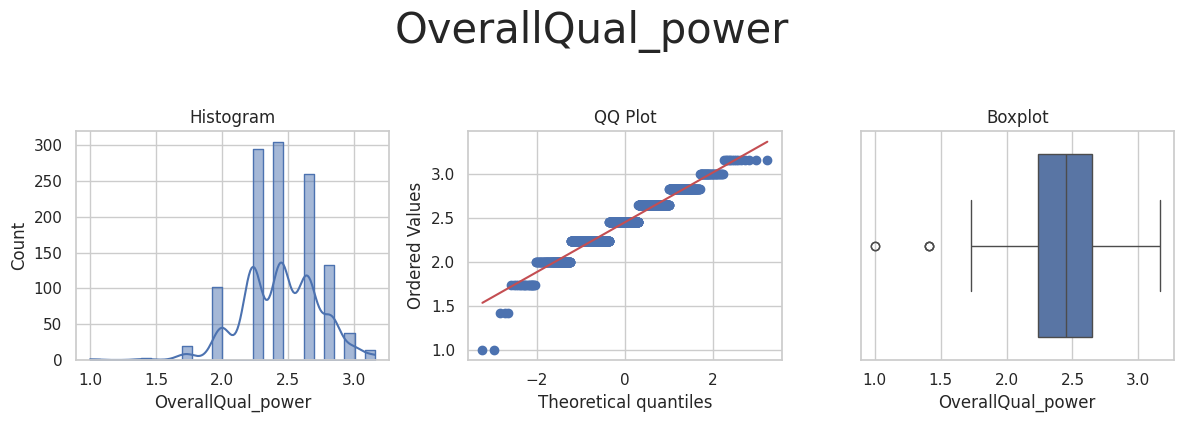

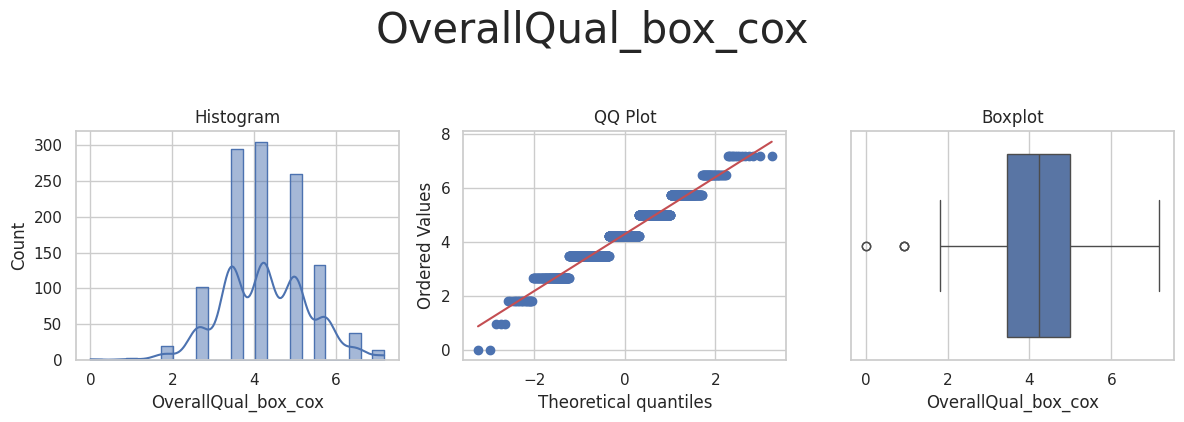

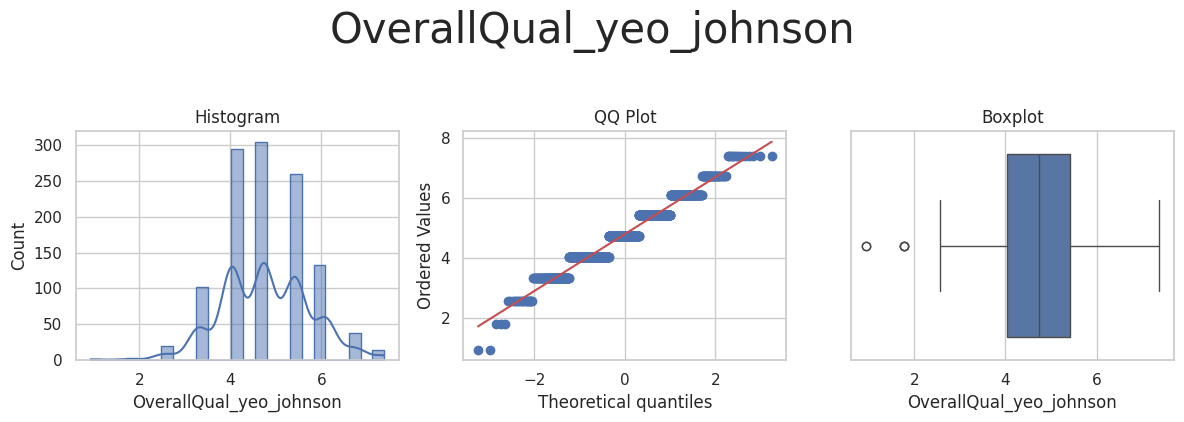



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



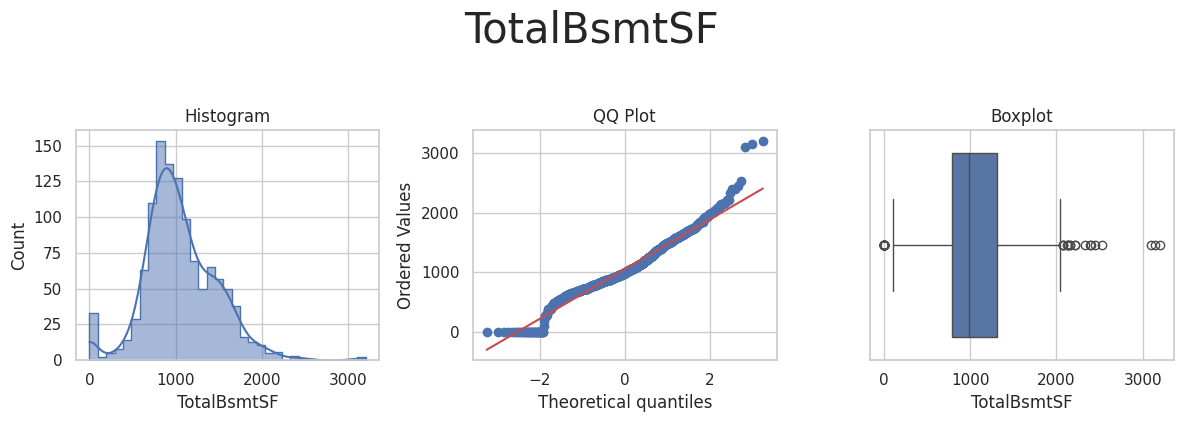

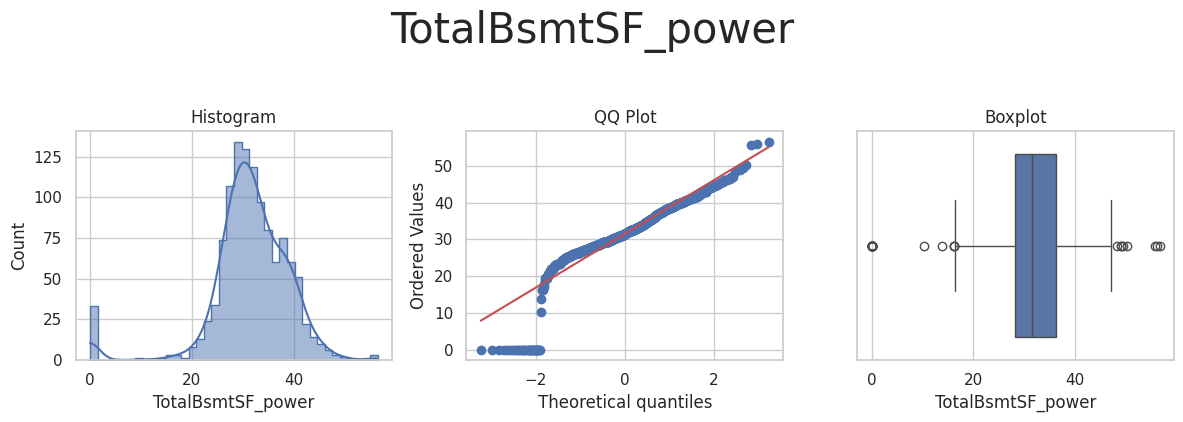

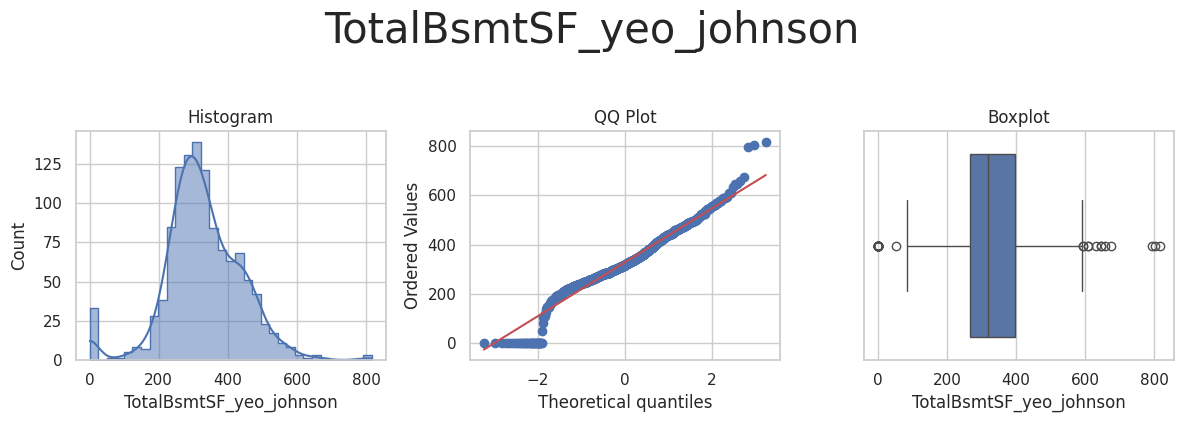



* Variable Analyzed: WoodDeckSF
* Applied transformation: ['WoodDeckSF_power', 'WoodDeckSF_yeo_johnson'] 



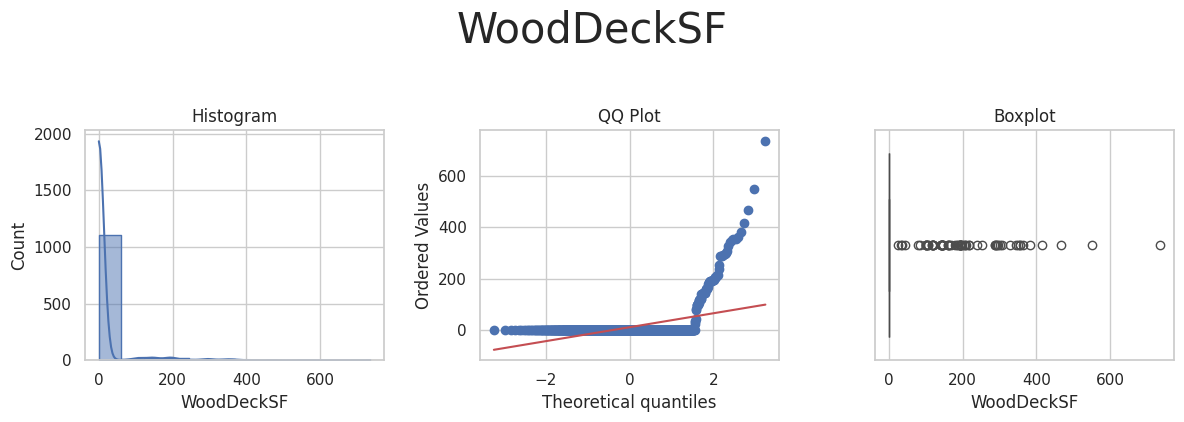

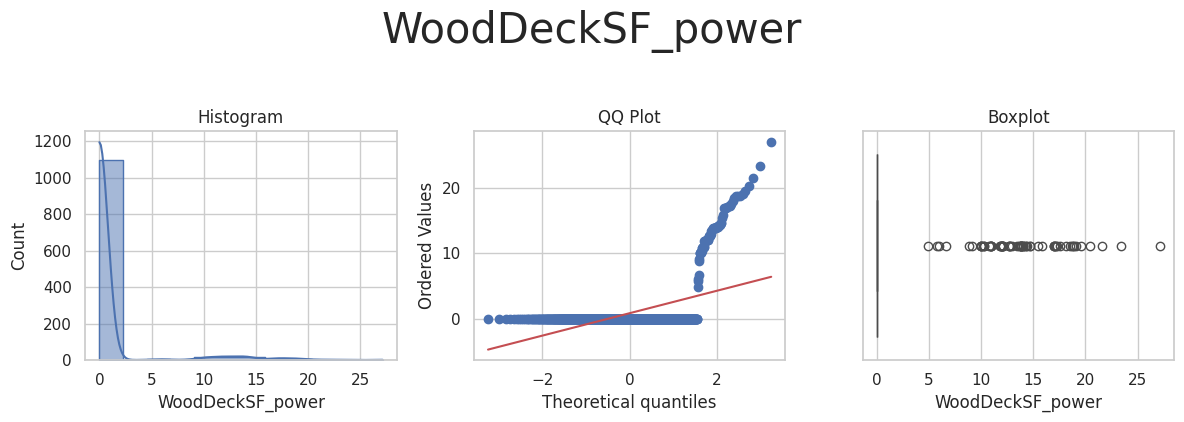

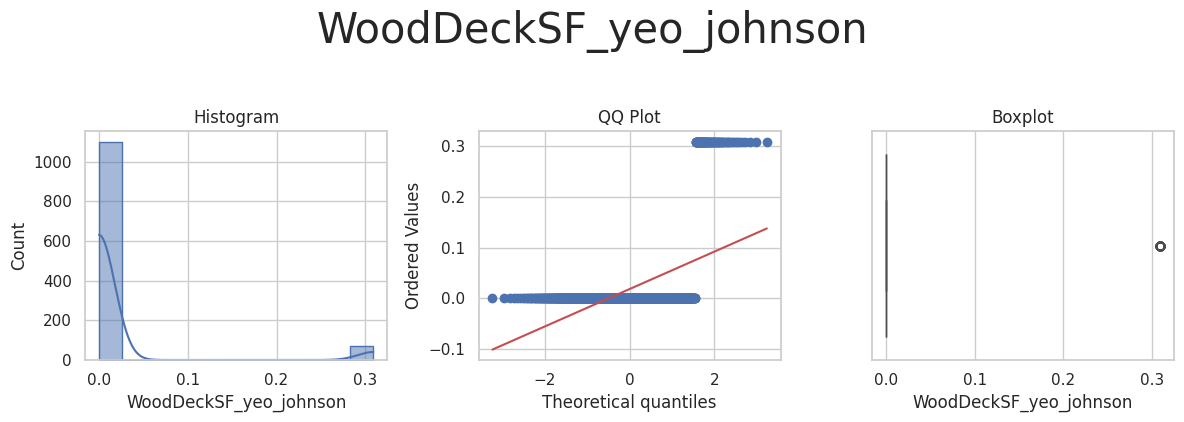



* Variable Analyzed: YearBuilt
* Applied transformation: ['YearBuilt_log_e', 'YearBuilt_log_10', 'YearBuilt_reciprocal', 'YearBuilt_power', 'YearBuilt_box_cox', 'YearBuilt_yeo_johnson'] 



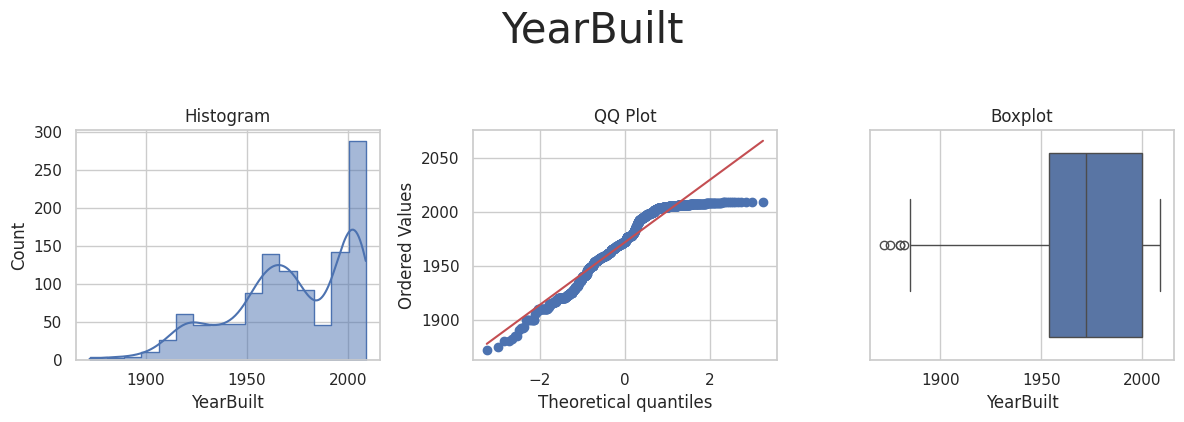

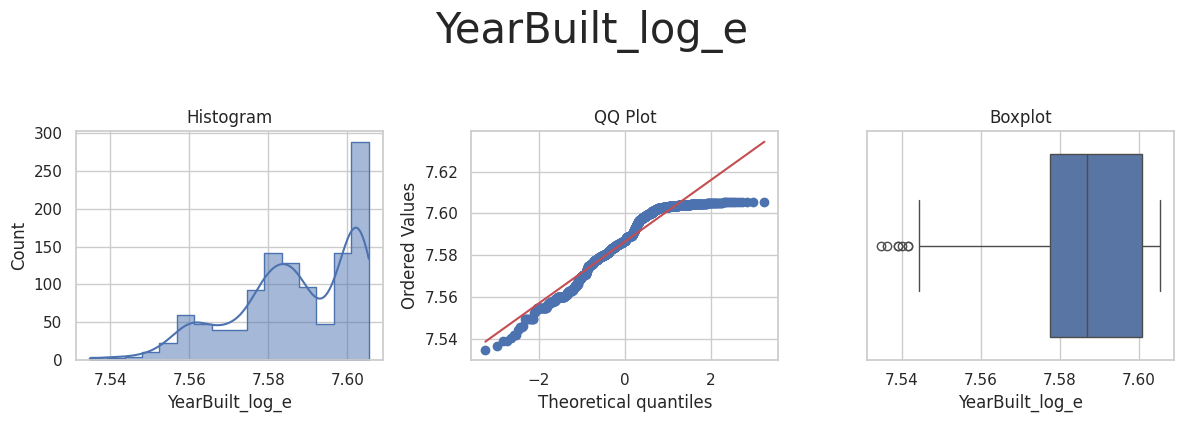

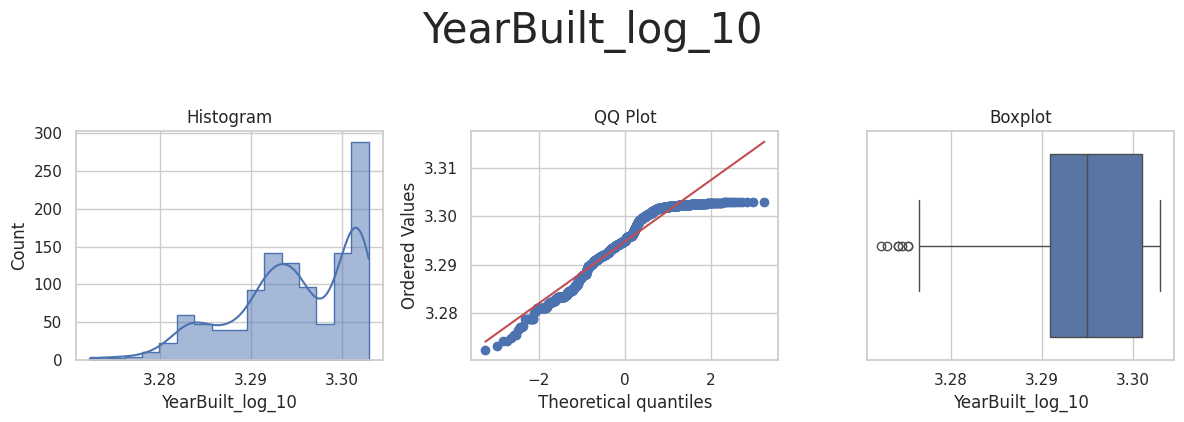

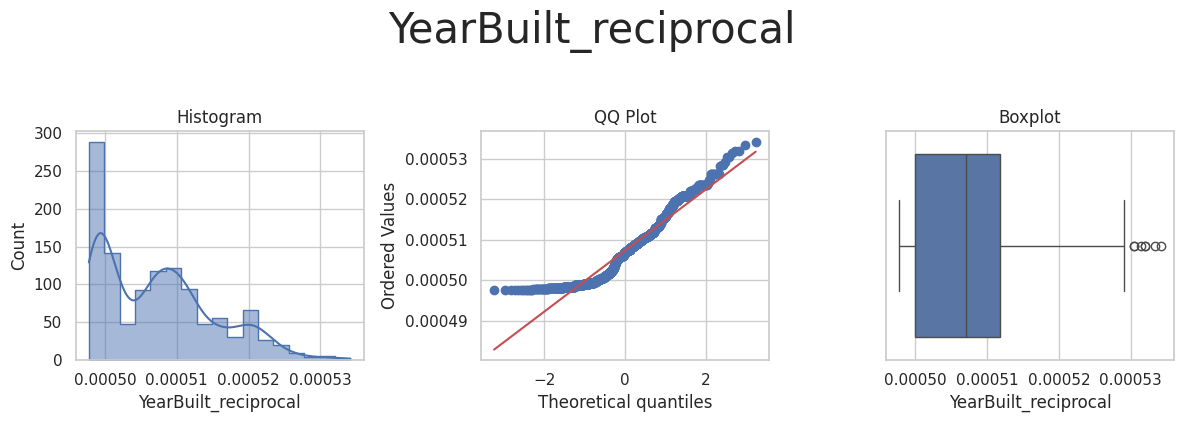

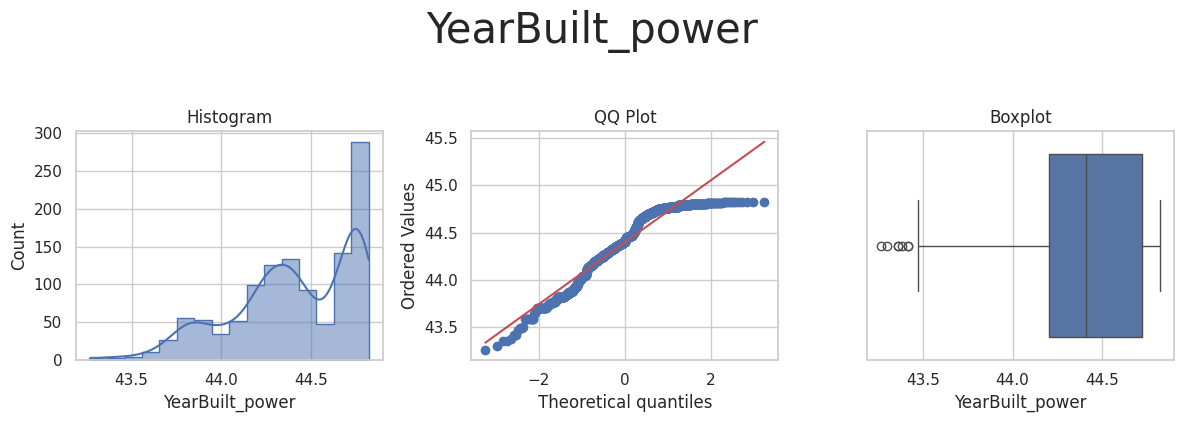

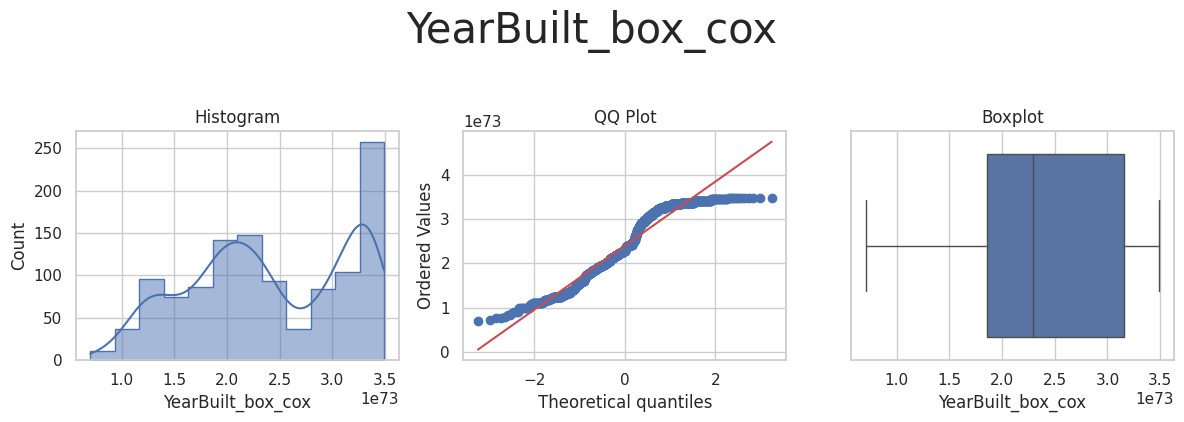

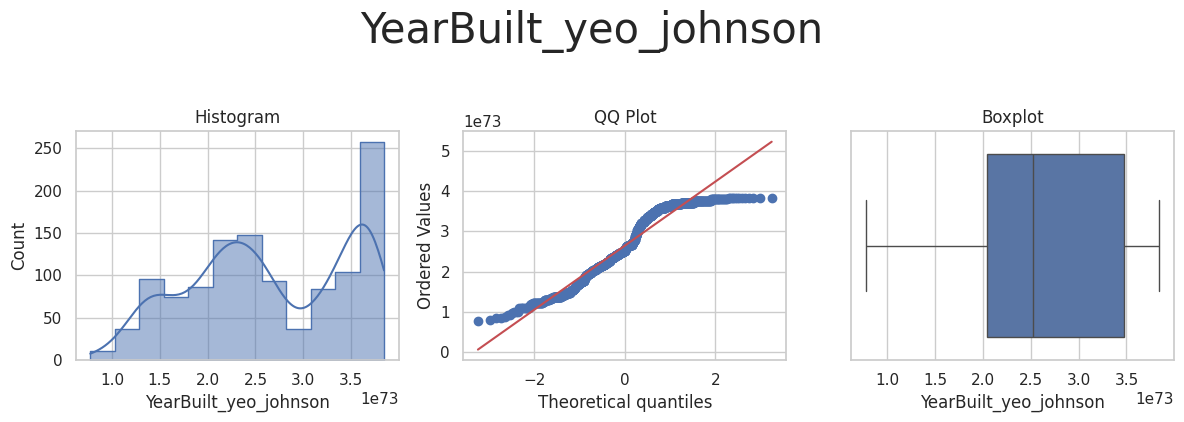



* Variable Analyzed: YearRemodAdd
* Applied transformation: ['YearRemodAdd_log_e', 'YearRemodAdd_log_10', 'YearRemodAdd_reciprocal', 'YearRemodAdd_power', 'YearRemodAdd_box_cox', 'YearRemodAdd_yeo_johnson'] 



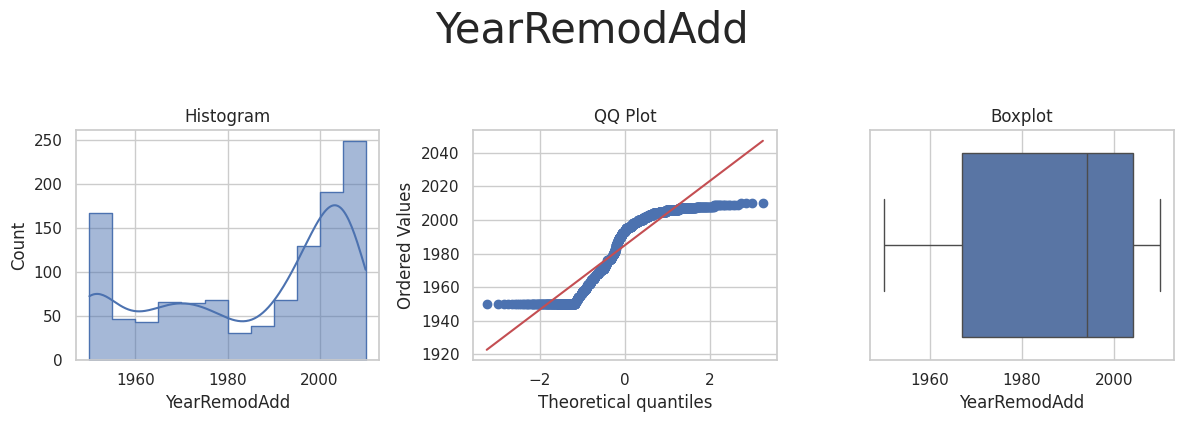

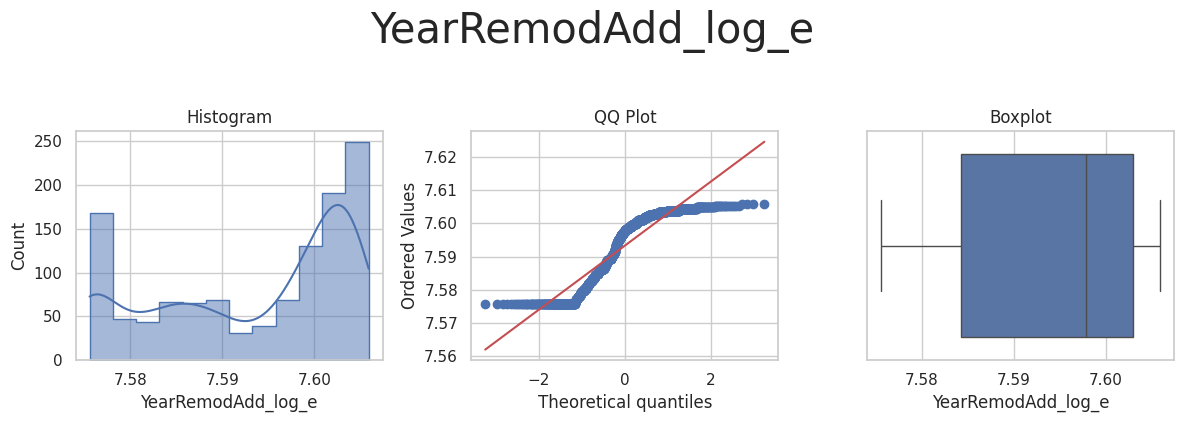

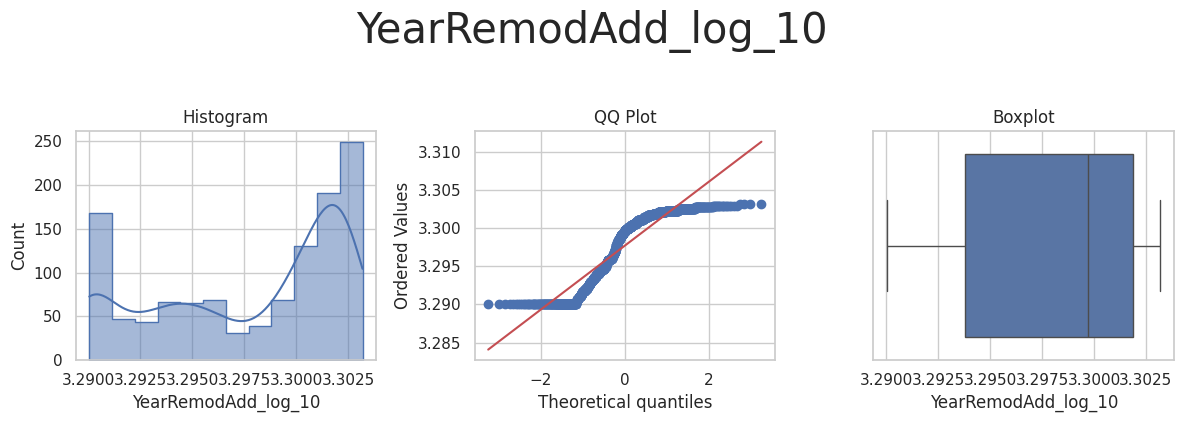

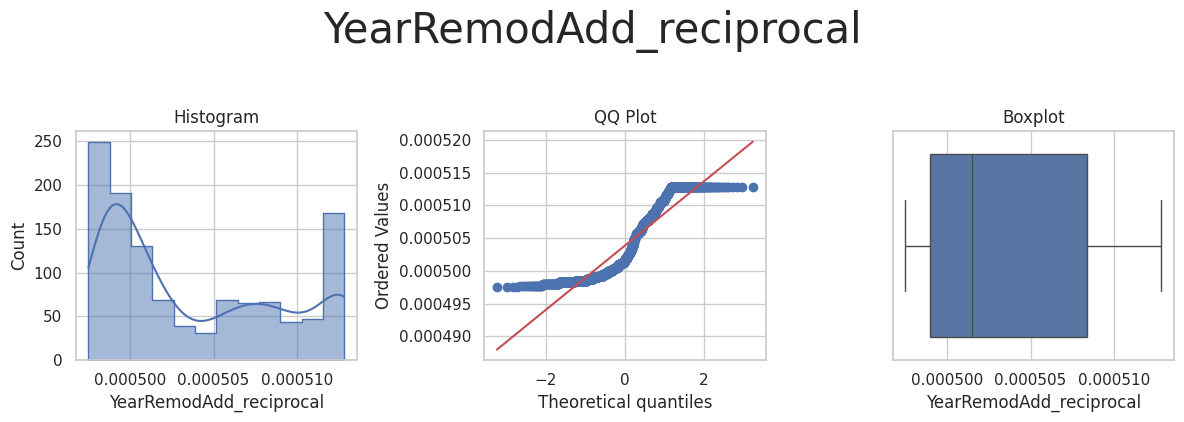

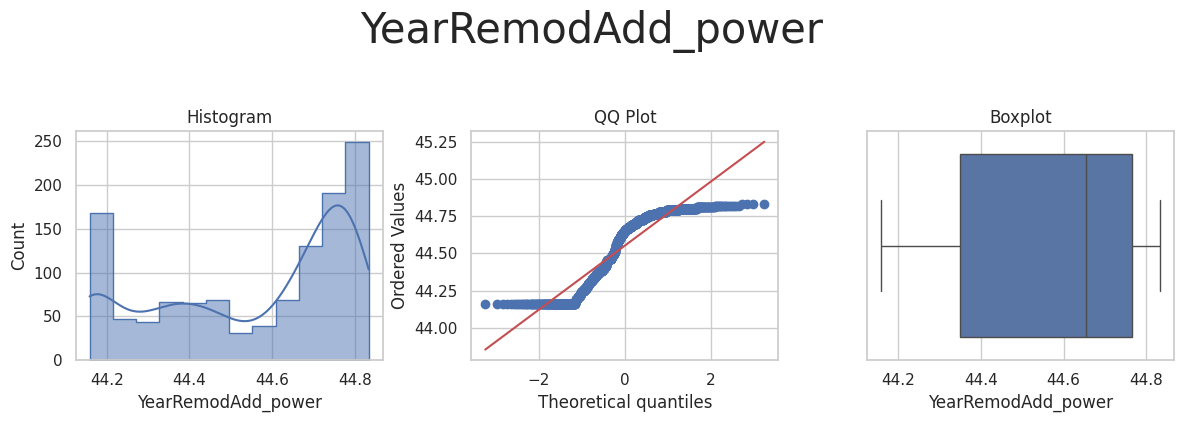

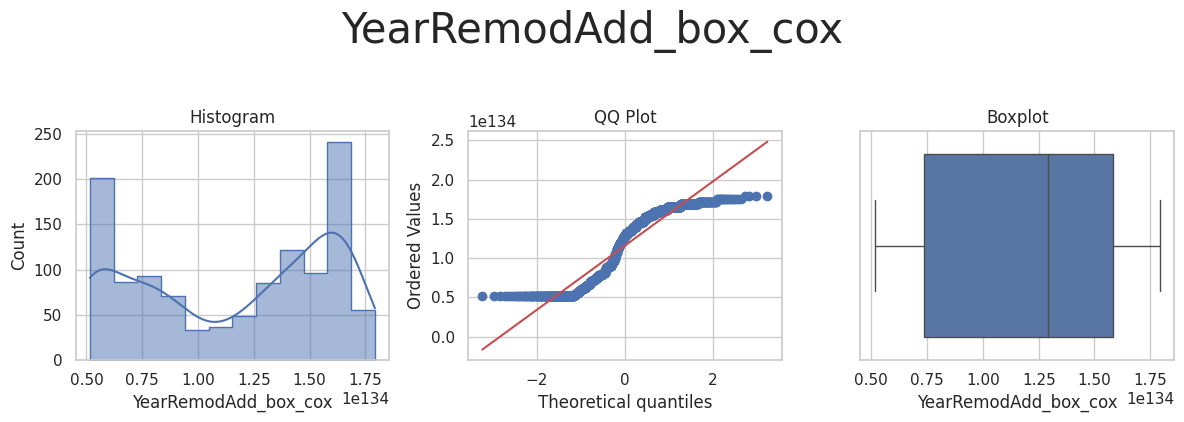

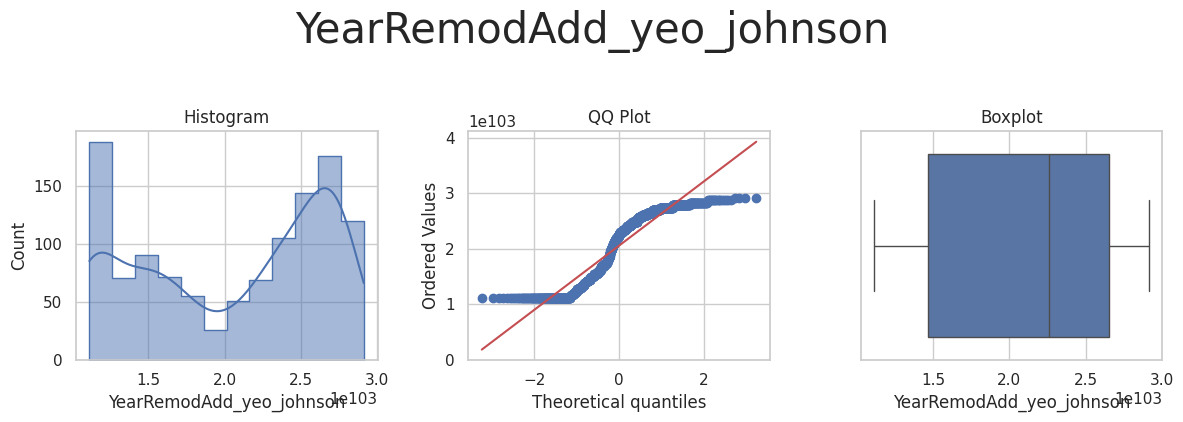

In [13]:
numerical_vars_engineering = FeatureEngineeringAnalysis(
    df=numerical_vars_engineering, analysis_type='numerical')

### Observations

|Variable|Analysis|	Selection|
|:----|:----|:----|
|1stFlrSF   |	Power and Log e transformations fit best. The data is normally distributed. Power has a slight positive skew so 	|Log
|2ndFlrSF   |	Power transformation fits best. Consider dropping zeroes.	|Power
|BedroomAbvGr|	Yeo transformation fits best	|Yeo
|BsmtFinSF1 |	Power transformation fits best. Normally distributed other than the zeroes	|Power
|BsmtUnfSF  |	Power + Yeo transformation fits best. Zeroes	|Power
|TotalBsmtSF|	Power transformation fits best	|Power
|GarageArea |	Power + Yeo transformation fits best. Zeroes and high outliers	|Power
|GarageYrBlt|	Power transformation fits best, values are negatively skewed.	|Power
|GrLivArea  |Log e transformations fit best but there are outliers at both ends. 	|Log e
|LotArea	|Yeo transformation fits best. Outliers on both sides	|Yeo
|LotFrontage|Power + Yeo transformation fits best. Outliers	|Power
|MasVnrArea	|Power transformation fits best. Zeroes	|No transformation
|EnclosedPorch|	No good transformations	|No transformation
|OpenPorchSF|Yeo transformation fits best, lots of zero values skewing the data	|Yeo
|OverallCond|Power + Yeo transformation fits best	|Power
|OverallQual|Power + Yeo transformation fits best, power appears less skewed	|Power
|WoodDeckSF	|No good transformations	|No transformation
|YearBuilt	|Power + Yeo transformation fits best	|Power
|YearRemodAdd|	Power + Yeo transformation fits best	|Power


In [14]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline ([

        ("PowerTransformer", vt.PowerTransformer(
                         variables = [
                             '2ndFlrSF',
                             'BsmtFinSF1',
                             'BsmtUnfSF', 
                             'OverallQual',
                             'YearBuilt',
                             'YearRemodAdd',
                             'TotalBsmtSF',
                             'GarageArea',
                             'GarageYrBlt',
                             'OverallCond'
                             ])),
        
        ("LogTransformer", vt.LogTransformer(
                         variables = [
                             '1stFlrSF',
                             'GrLivArea'
                             ])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(
                         variables = [
                             'LotArea',
                             'OpenPorchSF'
                             ])),

        ## ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5,
        ##                 variables = [''])),
])

train_set = pipeline.fit_transform(TrainSet)
test_set = pipeline.transform(TestSet)

print("Numerical transformation done!")



Numerical transformation done!


## Smart Correlation

All variables are in scope for smart correlation. 

In [16]:
smart_correlation_df = TrainSet.copy()
smart_correlation_df.head()

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0      1232       0.0           2.0             0         724             0   
1      1445     689.0           5.0             1           0             1   
2      1337       0.0           3.0             2         699             0   
3       958       0.0           2.0             1         120             2   
4      1134       0.0           2.0             1         588             3   

   BsmtUnfSF  EnclosedPorch  GarageArea  GarageFinish  ...  LotFrontage  \
0        508            0.0         632             0  ...         64.0   
1        844          268.0         441             1  ...         69.5   
2        638            0.0         531             2  ...         65.0   
3        958            0.0         440             2  ...         69.5   
4        422            0.0         254             0  ...         70.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  WoodDeckSF  \
0        82.0            0            5            7         1232         0.0   
1         0.0           60            6            6          844         0.0   
2         0.0           39            5            7         1337         0.0   
3         0.0          205            5            6         1078         0.0   
4        45.0           16            7            5         1010         0.0   

   YearBuilt  YearRemodAdd  SalePrice  
0       2007          2007     194500  
1       1916          1994     214500  
2       2003          2003     185000  
3       1976          1976     128000  
4       1960          2002     135000  

[5 rows x 24 columns]

Apply the transformation

In [21]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.8,selection_method="variance", missing_values='ignore')

corr_sel.fit_transform(smart_correlation_df)
corr_sel.correlated_feature_sets_

[{'1stFlrSF', 'TotalBsmtSF'},
 {'GarageYrBlt', 'YearBuilt'},
 {'OverallQual', 'SalePrice'}]

In [20]:
corr_sel.features_to_drop_

['1stFlrSF', 'GarageYrBlt', 'OverallQual']

## Conclusion

Ordinal Encoder: []
Log Transformer: []
Power Transformer: []
Yeo Johnson Transformer: []
Most important features following feature engineering: [[{'1stFlrSF', 'TotalBsmtSF'},
 {'GarageYrBlt', 'YearBuilt'},
 {'OverallQual', 'SalePrice'}]]
Smart Correlated features to drop: ['1stFlrSF', 'GarageYrBlt', 'OverallQual']

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [15]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)


IndentationError: expected an indented block after 'try' statement on line 2 (2852421808.py, line 5)